In [1]:
from __future__ import absolute_import, division, print_function

import base64
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import reverb
import sys

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.environments import utils
from tf_agents.networks import q_rnn_network


sys.path.append('/home/jorge/Documentos/TFG/entorno')
from trading_env_2 import TradingEnv

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

tf.config.list_physical_devices('GPU')

root_dir = '/home/jorge/Documentos/TFG/puntos_control'

root_dir = os.path.expanduser(root_dir)
train_dir = os.path.join(root_dir, 'train')

2023-03-24 10:35:06.769819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 10:35:06.841206: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-24 10:35:07.222218: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/extras/CUPTI/lib64:/home/jorge/miniconda3/envs/tf/lib/
2023-03-24 10:3

# Preparacion de los datos

In [2]:
df = pd.read_csv('/home/jorge/Documentos/TFG/datasets/BTCUSDT_spot_1m_.csv', index_col = 'open_time')
df

,open,high,low,close,volume,rvol,high_per,low_per,close_per,close_money
open_time,,,,,,,,,,
2019-01-11 00:00:00,3585.88,3589.07,3585.26,3586.70,24.13,0.58,0.09,0.02,0.02,0.23
2019-01-11 00:01:00,3586.30,3586.70,3557.52,3567.60,228.68,6.43,0.01,0.80,-0.52,-5.24
2019-01-11 00:02:00,3567.60,3579.69,3560.88,3576.09,136.27,4.63,0.34,0.19,0.24,2.37
2019-01-11 00:03:00,3576.61,3579.79,3567.63,3577.53,48.13,1.93,0.09,0.25,0.03,0.26
2019-01-11 00:04:00,3577.52,3579.99,3571.44,3577.73,25.05,1.05,0.07,0.17,0.01,0.06
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:55:00,16540.42,16540.92,16537.71,16539.28,36.24,0.31,0.00,0.02,-0.01,-0.07
2022-12-31 23:56:00,16538.65,16540.53,16538.38,16540.52,38.59,0.39,0.01,0.00,0.01,0.11
2022-12-31 23:57:00,16540.52,16540.79,16535.05,16537.78,53.36,0.94,0.00,0.03,-0.02,-0.17


In [3]:
df_sc = df[['close_per']]
df_sc.head()

,close_per
open_time,
2019-01-11 00:00:00,0.02
2019-01-11 00:01:00,-0.52
2019-01-11 00:02:00,0.24
2019-01-11 00:03:00,0.03
2019-01-11 00:04:00,0.01


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_sc[['close_sc','rvol']] = scaler.fit_transform(df[['close_per','rvol']])

df_sc

/tmp/ipykernel_5487/3553793866.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sc[['close_sc','rvol']] = scaler.fit_transform(df[['close_per','rvol']])
/tmp/ipykernel_5487/3553793866.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sc[['close_sc','rvol']] = scaler.fit_transform(df[['close_per','rvol']])


,close_per,close_sc,rvol
open_time,,,
2019-01-11 00:00:00,0.02,0.524590,0.002214
2019-01-11 00:01:00,-0.52,0.487705,0.024549
2019-01-11 00:02:00,0.24,0.539617,0.017676
2019-01-11 00:03:00,0.03,0.525273,0.007368
2019-01-11 00:04:00,0.01,0.523907,0.004009
...,...,...,...
2022-12-31 23:55:00,-0.01,0.522541,0.001184
2022-12-31 23:56:00,0.01,0.523907,0.001489
2022-12-31 23:57:00,-0.02,0.521858,0.003589


In [5]:
from random import shuffle

def create_time_series(dataset):    
    X = []
    
    for i in range(20,dataset.shape[0],20):        
        X.append(dataset[i-20:i,:])
        
    return np.array(X)

In [6]:
from sklearn.model_selection import train_test_split

#df_diff_sc = arr_diff[:,3].reshape(-1, 1)

X = create_time_series(np.array(df_sc[['close_per','close_sc','rvol']]))
X.shape

(104271, 20, 3)

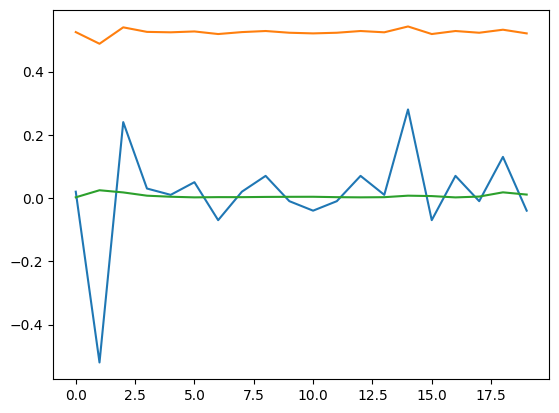

In [9]:
plt.plot(X[0])
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size=0.10,random_state = 42)
X_train.shape,X_test.shape

((93843, 20, 3), (10428, 20, 3))

# Hiperparamatros

In [10]:
num_iterations = 500000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 1000000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 1  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

checkpoint_interval = 100000
buffer_interval = num_iterations/2

# Entorno

In [11]:
env = TradingEnv(X_train)

In [12]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(10, 2), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)


In [13]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [14]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=2)


In [15]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[0.52663934, 0.00511587],
       [0.5191257 , 0.00637575],
       [0.5300546 , 0.00744474],
       [0.51775956, 0.00355057],
       [0.5280055 , 0.00503951],
       [0.534153  , 0.01118619],
       [0.51980877, 0.01095713],
       [0.52868855, 0.00660482],
       [0.5239071 , 0.00809377],
       [0.5136612 , 0.01004085]], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(0., dtype=float32),
 'observation': array([[0.5191257 , 0.00637575],
       [0.5300546 , 0.00744474],
       [0.51775956, 0.00355057],
       [0.5280055 , 0.00503951],
       [0.534153  , 0.01118619],
       [0.51980877, 0.01095713],
       [0.52868855, 0.00660482],
       [0.5239071 , 0.00809377],
       [0.5136612 , 0.01004085],
       [0.5191257 , 0.00626121]], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(2, dtype=int32)})

In [16]:
train_py_env = TradingEnv(X_train)
eval_py_env = TradingEnv(X_test)

In [17]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Agente

In [18]:
'''
fc_layer_params = (100, 100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

#Capa de preprocessamiento
preprocessing_layer = tf.keras.layers.Flatten()

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

q_net = sequential.Sequential([preprocessing_layer] + dense_layers + [q_values_layer])
'''

lstm_size=(50,50)

#create a q_RNNnet
q_net = q_rnn_network.QRnnNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    input_fc_layer_params=None,
    lstm_size=lstm_size,
    output_fc_layer_params=None)    

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.compat.v1.train.get_or_create_global_step()

agent = dqn_agent.DdqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

2023-03-24 10:41:12.967464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Politicas

In [20]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [21]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [22]:
example_environment = tf_py_environment.TFPyEnvironment(
    TradingEnv(X_train))

In [23]:
time_step = example_environment.reset()

In [24]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, state=(), info=())

# Métricas y evaluación

In [25]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    total_steps = 0.0
    for _ in range(num_episodes):

        policy_state = policy.get_initial_state(environment.batch_size)
        time_step = environment.reset()
        episode_return = 0.0
        episode_steps = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step,policy_state)
            time_step = environment.step(action_step.action)
            policy_state = action_step.state
            episode_return = time_step.reward
            episode_steps += 1.0
        total_return = episode_return
        total_steps += episode_steps

    avg_return = total_return / num_episodes
    avg_steps = total_steps / num_episodes
    return avg_return.numpy()[0],avg_steps


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [26]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

(0.15, 3.0)

# Buffer de reproducción

In [27]:
table_name = 'priotity_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Prioritized(0.8),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpov_og0lw.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpov_og0lw
[reverb/cc/platform/default/server.cc:71] Started replay server on port 40547


In [28]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(2, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(10, 2), dtype=tf.float32, name='observation', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [29]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

# Recolección de datos 

In [30]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(0., dtype=float32),
  'observation': array([[0.5252732 , 0.00229069],
        [0.5259563 , 0.00248158],
        [0.51980877, 0.00301607],
        [0.52937156, 0.00282518],
        [0.52117485, 0.00194709],
        [0.51571035, 0.00389417],
        [0.52663934, 0.00251976],
        [0.5280055 , 0.00259611],
        [0.5191257 , 0.00423777],
        [0.5307377 , 0.00305425]], dtype=float32),
  'reward': array(0.05, dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [31]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 10, 2), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [32]:
iterator = iter(dataset)
print(iterator)

# Checkpoint

In [33]:
train_checkpointer = common.Checkpointer(
    ckpt_dir=train_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    global_step=train_step_counter
)

In [34]:
train_checkpointer.initialize_or_restore()

In [35]:
agent.train_step_counter.numpy()

0

# Entrenando al agente

In [36]:
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Evaluate the agent's policy once before training.
avg_return,_ = compute_avg_return(eval_env, agent.collect_policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
policy_state = agent.policy.get_initial_state(train_env.batch_size)
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

    # Collect a few steps and save to the replay buffer.
    time_step, policy_state = collect_driver.run(time_step,policy_state)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return,avg_steps = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Steps = {1}, Average Return = {2}'.format(step,avg_steps,avg_return))
        returns.append(avg_return)
        
    if step % checkpoint_interval == 0:
        train_checkpointer.save(train_step_counter)
                
    #if step % buffer_interval ==0:
    #    rb_checkpointer.save(global_step=global_step.numpy())

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (5487) so Table priotity_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (5487) so Table priotity_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (5487) so Table priotity_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (5487) so Table priotity_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (5487) so Table priotity_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (5487) so Table priotity_table is accessed directly without gRPC.


step = 200: loss = 0.029081527143716812
step = 400: loss = 0.01608535274863243
step = 600: loss = 0.02352064475417137
step = 800: loss = 0.009108621627092361
step = 1000: loss = 0.01859687641263008
step = 1000: Average Steps = 1.0, Average Return = 0.0
step = 1200: loss = 0.008384228684008121
step = 1400: loss = 0.005480722989886999
step = 1600: loss = 0.0043580904603004456
step = 1800: loss = 0.006163099780678749
step = 2000: loss = 0.00691893370822072
step = 2000: Average Steps = 1.0, Average Return = 0.0
step = 2200: loss = 0.003670564154163003
step = 2400: loss = 0.004425884690135717
step = 2600: loss = 0.010132187977433205
step = 2800: loss = 0.001647870521992445
step = 3000: loss = 0.012820761650800705
step = 3000: Average Steps = 10.0, Average Return = 0.14000000059604645
step = 3200: loss = 0.011946536600589752
step = 3400: loss = 0.015556002035737038
step = 3600: loss = 0.01691882126033306
step = 3800: loss = 0.007473120000213385
step = 4000: loss = 0.015260564163327217
step =

step = 30400: loss = 0.010633191093802452
step = 30600: loss = 0.02359015867114067
step = 30800: loss = 0.01453655119985342
step = 31000: loss = 0.02838769555091858
step = 31000: Average Steps = 1.0, Average Return = 0.0
step = 31200: loss = 0.017695311456918716
step = 31400: loss = 0.04324262961745262
step = 31600: loss = 0.026728058233857155
step = 31800: loss = 0.007313065696507692
step = 32000: loss = 0.03722541779279709
step = 32000: Average Steps = 1.0, Average Return = 0.0
step = 32200: loss = 0.017936866730451584
step = 32400: loss = 0.02047598734498024
step = 32600: loss = 0.02535782754421234
step = 32800: loss = 0.020385898649692535
step = 33000: loss = 0.025716494768857956
step = 33000: Average Steps = 1.0, Average Return = 0.0
step = 33200: loss = 0.03659258782863617
step = 33400: loss = 0.020419500768184662
step = 33600: loss = 0.02398199960589409
step = 33800: loss = 0.02139878086745739
step = 34000: loss = 0.014735416509211063
step = 34000: Average Steps = 10.0, Average 

step = 61000: loss = 0.030594104900956154
step = 61000: Average Steps = 1.0, Average Return = 0.0
step = 61200: loss = 0.011590475216507912
step = 61400: loss = 0.045976657420396805
step = 61600: loss = 0.015013850294053555
step = 61800: loss = 0.02650851383805275
step = 62000: loss = 0.01583883725106716
step = 62000: Average Steps = 1.0, Average Return = 0.0
step = 62200: loss = 0.009473605081439018
step = 62400: loss = 0.0268250685185194
step = 62600: loss = 0.022063570097088814
step = 62800: loss = 0.014217167161405087
step = 63000: loss = 0.01045187283307314
step = 63000: Average Steps = 1.0, Average Return = 0.0
step = 63200: loss = 0.01974513567984104
step = 63400: loss = 0.02219201624393463
step = 63600: loss = 0.020555198192596436
step = 63800: loss = 0.015517023392021656
step = 64000: loss = 0.022896476089954376
step = 64000: Average Steps = 10.0, Average Return = 0.07999999821186066
step = 64200: loss = 0.011561039835214615
step = 64400: loss = 0.03798947483301163
step = 6460

step = 91200: loss = 0.01283546444028616
step = 91400: loss = 0.029578497633337975
step = 91600: loss = 0.020602364093065262
step = 91800: loss = 0.009580985642969608
step = 92000: loss = 0.017416812479496002
step = 92000: Average Steps = 10.0, Average Return = -0.009999999776482582
step = 92200: loss = 0.031446054577827454
step = 92400: loss = 0.01977246254682541
step = 92600: loss = 0.014059673994779587
step = 92800: loss = 0.021201949566602707
step = 93000: loss = 0.02019451931118965
step = 93000: Average Steps = 10.0, Average Return = 0.33000001311302185
step = 93200: loss = 0.02385437674820423
step = 93400: loss = 0.053547102957963943
step = 93600: loss = 0.022882474586367607
step = 93800: loss = 0.030452705919742584
step = 94000: loss = 0.02973036840558052
step = 94000: Average Steps = 10.0, Average Return = -0.25
step = 94200: loss = 0.014133509248495102
step = 94400: loss = 0.02780415490269661
step = 94600: loss = 0.031885307282209396
step = 94800: loss = 0.03651077300310135
st

step = 121200: loss = 0.03447205573320389
step = 121400: loss = 0.020620601251721382
step = 121600: loss = 0.01554091926664114
step = 121800: loss = 0.016742637380957603
step = 122000: loss = 0.03588969260454178
step = 122000: Average Steps = 1.0, Average Return = 0.0
step = 122200: loss = 0.03622132167220116
step = 122400: loss = 0.022385556250810623
step = 122600: loss = 0.03259945660829544
step = 122800: loss = 0.023823212832212448
step = 123000: loss = 0.02090543322265148
step = 123000: Average Steps = 1.0, Average Return = 0.0
step = 123200: loss = 0.022410284727811813
step = 123400: loss = 0.015631016343832016
step = 123600: loss = 0.01649707742035389
step = 123800: loss = 0.03594726324081421
step = 124000: loss = 0.015531652607023716
step = 124000: Average Steps = 10.0, Average Return = -0.10999999940395355
step = 124200: loss = 0.020246312022209167
step = 124400: loss = 0.03958206623792648
step = 124600: loss = 0.023862428963184357
step = 124800: loss = 0.014977536164224148
ste

step = 151200: loss = 0.011238617822527885
step = 151400: loss = 0.02948913164436817
step = 151600: loss = 0.04723770543932915
step = 151800: loss = 0.01562708616256714
step = 152000: loss = 0.01500076986849308
step = 152000: Average Steps = 10.0, Average Return = -0.14000000059604645
step = 152200: loss = 0.023819060996174812
step = 152400: loss = 0.016389645636081696
step = 152600: loss = 0.007430028170347214
step = 152800: loss = 0.03264433145523071
step = 153000: loss = 0.01737762987613678
step = 153000: Average Steps = 10.0, Average Return = 0.3100000023841858
step = 153200: loss = 0.023820705711841583
step = 153400: loss = 0.010327236726880074
step = 153600: loss = 0.031610701233148575
step = 153800: loss = 0.016322482377290726
step = 154000: loss = 0.022028740495443344
step = 154000: Average Steps = 1.0, Average Return = 0.0
step = 154200: loss = 0.020496025681495667
step = 154400: loss = 0.02831117808818817
step = 154600: loss = 0.019909247756004333
step = 154800: loss = 0.0134

step = 181200: loss = 0.01220104843378067
step = 181400: loss = 0.0770798921585083
step = 181600: loss = 0.012243527919054031
step = 181800: loss = 0.03790624439716339
step = 182000: loss = 0.08997119963169098
step = 182000: Average Steps = 10.0, Average Return = -0.07000000029802322
step = 182200: loss = 0.021076714619994164
step = 182400: loss = 0.016127057373523712
step = 182600: loss = 0.020529452711343765
step = 182800: loss = 0.03202426806092262
step = 183000: loss = 0.015347304753959179
step = 183000: Average Steps = 1.0, Average Return = 0.0
step = 183200: loss = 0.027205556631088257
step = 183400: loss = 0.036210156977176666
step = 183600: loss = 0.028811315074563026
step = 183800: loss = 0.017103005200624466
step = 184000: loss = 0.021109260618686676
step = 184000: Average Steps = 1.0, Average Return = 0.0
step = 184200: loss = 0.02567785605788231
step = 184400: loss = 0.01889123022556305
step = 184600: loss = 0.04085170477628708
step = 184800: loss = 0.013888904824852943
ste

step = 211200: loss = 0.02472739852964878
step = 211400: loss = 0.014262793585658073
step = 211600: loss = 0.019681595265865326
step = 211800: loss = 0.0367606095969677
step = 212000: loss = 0.013827548362314701
step = 212000: Average Steps = 1.0, Average Return = 0.0
step = 212200: loss = 0.008728442713618279
step = 212400: loss = 0.02671973779797554
step = 212600: loss = 0.043160051107406616
step = 212800: loss = 0.010051810182631016
step = 213000: loss = 0.01165633462369442
step = 213000: Average Steps = 1.0, Average Return = 0.0
step = 213200: loss = 0.03060467354953289
step = 213400: loss = 0.027575746178627014
step = 213600: loss = 0.014716273173689842
step = 213800: loss = 0.009350623935461044
step = 214000: loss = 0.017962239682674408
step = 214000: Average Steps = 1.0, Average Return = 0.0
step = 214200: loss = 0.013185634277760983
step = 214400: loss = 0.037220727652311325
step = 214600: loss = 0.02449691668152809
step = 214800: loss = 0.015434285625815392
step = 215000: loss

step = 241200: loss = 0.017825160175561905
step = 241400: loss = 0.023792076855897903
step = 241600: loss = 0.024020854383707047
step = 241800: loss = 0.02826695516705513
step = 242000: loss = 0.03156908601522446
step = 242000: Average Steps = 1.0, Average Return = 0.0
step = 242200: loss = 0.01865619607269764
step = 242400: loss = 0.16658921539783478
step = 242600: loss = 0.02942073531448841
step = 242800: loss = 0.07609927654266357
step = 243000: loss = 0.010084353387355804
step = 243000: Average Steps = 1.0, Average Return = 0.0
step = 243200: loss = 0.01740092784166336
step = 243400: loss = 0.013116735965013504
step = 243600: loss = 0.024160997942090034
step = 243800: loss = 0.017745699733495712
step = 244000: loss = 0.03793669119477272
step = 244000: Average Steps = 10.0, Average Return = 0.07000000029802322
step = 244200: loss = 0.016652964055538177
step = 244400: loss = 0.027738530188798904
step = 244600: loss = 0.03353389352560043
step = 244800: loss = 0.021346017718315125
step

step = 271200: loss = 0.017577705904841423
step = 271400: loss = 0.018304791301488876
step = 271600: loss = 0.019098535180091858
step = 271800: loss = 0.011202693916857243
step = 272000: loss = 0.02807767316699028
step = 272000: Average Steps = 1.0, Average Return = 0.0
step = 272200: loss = 0.07148057967424393
step = 272400: loss = 0.013936569914221764
step = 272600: loss = 0.010505227372050285
step = 272800: loss = 0.017772600054740906
step = 273000: loss = 0.009765911847352982
step = 273000: Average Steps = 10.0, Average Return = -0.20000000298023224
step = 273200: loss = 0.01849832572042942
step = 273400: loss = 0.024100784212350845
step = 273600: loss = 0.02957058697938919
step = 273800: loss = 0.01776689663529396
step = 274000: loss = 0.0152922747656703
step = 274000: Average Steps = 1.0, Average Return = 0.0
step = 274200: loss = 0.034882280975580215
step = 274400: loss = 0.026212584227323532
step = 274600: loss = 0.020999334752559662
step = 274800: loss = 0.01703583635389805
st

step = 301200: loss = 0.020072752609848976
step = 301400: loss = 0.01365988701581955
step = 301600: loss = 0.03566804155707359
step = 301800: loss = 0.021377481520175934
step = 302000: loss = 0.010499190539121628
step = 302000: Average Steps = 10.0, Average Return = 0.15000000596046448
step = 302200: loss = 0.0288190059363842
step = 302400: loss = 0.05310802161693573
step = 302600: loss = 0.03311966732144356
step = 302800: loss = 0.021675104275345802
step = 303000: loss = 0.06549409031867981
step = 303000: Average Steps = 10.0, Average Return = 0.17000000178813934
step = 303200: loss = 0.0167807936668396
step = 303400: loss = 0.014045135118067265
step = 303600: loss = 0.016562607139348984
step = 303800: loss = 0.03307574242353439
step = 304000: loss = 0.015329115092754364
step = 304000: Average Steps = 1.0, Average Return = 0.0
step = 304200: loss = 0.017324885353446007
step = 304400: loss = 0.024209091439843178
step = 304600: loss = 0.02575835958123207
step = 304800: loss = 0.03130529

step = 331200: loss = 0.02654363214969635
step = 331400: loss = 0.0245191790163517
step = 331600: loss = 0.03894124925136566
step = 331800: loss = 0.0164027139544487
step = 332000: loss = 0.0129780825227499
step = 332000: Average Steps = 10.0, Average Return = -0.07000000029802322
step = 332200: loss = 0.009094594046473503
step = 332400: loss = 0.0180975291877985
step = 332600: loss = 0.01697191409766674
step = 332800: loss = 0.020340677350759506
step = 333000: loss = 0.008091922849416733
step = 333000: Average Steps = 1.0, Average Return = 0.0
step = 333200: loss = 0.02438637986779213
step = 333400: loss = 0.0200367234647274
step = 333600: loss = 0.019689803943037987
step = 333800: loss = 0.03470537066459656
step = 334000: loss = 0.017746739089488983
step = 334000: Average Steps = 1.0, Average Return = 0.0
step = 334200: loss = 0.02598751336336136
step = 334400: loss = 0.04308399558067322
step = 334600: loss = 0.015534290112555027
step = 334800: loss = 0.01488023716956377
step = 33500

step = 361200: loss = 0.016798818483948708
step = 361400: loss = 0.012465104460716248
step = 361600: loss = 0.014385766349732876
step = 361800: loss = 0.01862184889614582
step = 362000: loss = 0.014200078323483467
step = 362000: Average Steps = 1.0, Average Return = 0.0
step = 362200: loss = 0.05052802711725235
step = 362400: loss = 0.02329721488058567
step = 362600: loss = 0.007527889683842659
step = 362800: loss = 0.023279240354895592
step = 363000: loss = 0.011596078984439373
step = 363000: Average Steps = 1.0, Average Return = 0.0
step = 363200: loss = 0.006736244075000286
step = 363400: loss = 0.023047957569360733
step = 363600: loss = 0.013407195918262005
step = 363800: loss = 0.04044158756732941
step = 364000: loss = 0.018951356410980225
step = 364000: Average Steps = 10.0, Average Return = -0.05999999865889549
step = 364200: loss = 0.04222647100687027
step = 364400: loss = 0.02027997374534607
step = 364600: loss = 0.013413118198513985
step = 364800: loss = 0.015446708537638187


step = 391200: loss = 0.014306721277534962
step = 391400: loss = 0.01104377955198288
step = 391600: loss = 0.046498171985149384
step = 391800: loss = 0.10971478372812271
step = 392000: loss = 0.05565682053565979
step = 392000: Average Steps = 1.0, Average Return = 0.0
step = 392200: loss = 0.3864282965660095
step = 392400: loss = 0.019833799451589584
step = 392600: loss = 0.02361132577061653
step = 392800: loss = 0.034840576350688934
step = 393000: loss = 0.11765636503696442
step = 393000: Average Steps = 1.0, Average Return = 0.0
step = 393200: loss = 0.013591231778264046
step = 393400: loss = 0.023316718637943268
step = 393600: loss = 0.019346876069903374
step = 393800: loss = 0.014155667275190353
step = 394000: loss = 0.03021256998181343
step = 394000: Average Steps = 1.0, Average Return = 0.0
step = 394200: loss = 0.012903861701488495
step = 394400: loss = 0.010648172348737717
step = 394600: loss = 0.014991814270615578
step = 394800: loss = 0.018603166565299034
step = 395000: loss 

step = 421200: loss = 0.024235185235738754
step = 421400: loss = 0.03444598242640495
step = 421600: loss = 0.017461121082305908
step = 421800: loss = 0.01649203710258007
step = 422000: loss = 0.01789068430662155
step = 422000: Average Steps = 1.0, Average Return = 0.0
step = 422200: loss = 0.02261538617312908
step = 422400: loss = 0.028650598600506783
step = 422600: loss = 0.029195165261626244
step = 422800: loss = 0.01790308579802513
step = 423000: loss = 0.023317446932196617
step = 423000: Average Steps = 10.0, Average Return = 0.11999999731779099
step = 423200: loss = 0.016457928344607353
step = 423400: loss = 0.03553658723831177
step = 423600: loss = 0.01750311441719532
step = 423800: loss = 0.01904927007853985
step = 424000: loss = 0.007561970967799425
step = 424000: Average Steps = 1.0, Average Return = 0.0
step = 424200: loss = 0.01246752217411995
step = 424400: loss = 0.02477272041141987
step = 424600: loss = 0.05051511526107788
step = 424800: loss = 0.02645295113325119
step = 

step = 451200: loss = 0.022716324776411057
step = 451400: loss = 0.013911755755543709
step = 451600: loss = 0.013015099801123142
step = 451800: loss = 0.028296854346990585
step = 452000: loss = 0.06259013712406158
step = 452000: Average Steps = 1.0, Average Return = 0.0
step = 452200: loss = 0.03294018656015396
step = 452400: loss = 0.014020904898643494
step = 452600: loss = 0.03453705087304115
step = 452800: loss = 0.03720824420452118
step = 453000: loss = 0.021951451897621155
step = 453000: Average Steps = 10.0, Average Return = 0.36000001430511475
step = 453200: loss = 0.0704251155257225
step = 453400: loss = 0.024770591408014297
step = 453600: loss = 0.036787062883377075
step = 453800: loss = 0.02175585925579071
step = 454000: loss = 0.04123712331056595
step = 454000: Average Steps = 10.0, Average Return = -0.23999999463558197
step = 454200: loss = 0.02496458776295185
step = 454400: loss = 0.0314597487449646
step = 454600: loss = 0.011019205674529076
step = 454800: loss = 0.0377361

step = 481200: loss = 0.0158645398914814
step = 481400: loss = 0.049081701785326004
step = 481600: loss = 0.0295857060700655
step = 481800: loss = 0.03317452594637871
step = 482000: loss = 0.027375979349017143
step = 482000: Average Steps = 1.0, Average Return = 0.0
step = 482200: loss = 0.011547529138624668
step = 482400: loss = 0.03468041867017746
step = 482600: loss = 0.019128350540995598
step = 482800: loss = 0.008646517060697079
step = 483000: loss = 0.024796966463327408
step = 483000: Average Steps = 1.0, Average Return = 0.0
step = 483200: loss = 0.02621825970709324
step = 483400: loss = 0.07341419160366058
step = 483600: loss = 0.042567454278469086
step = 483800: loss = 0.016247086226940155
step = 484000: loss = 0.026537500321865082
step = 484000: Average Steps = 1.0, Average Return = 0.0
step = 484200: loss = 0.019169235602021217
step = 484400: loss = 0.012675924226641655
step = 484600: loss = 0.21015627682209015
step = 484800: loss = 0.014664593152701855
step = 485000: loss =

# Visualización

(-1.237999939918518, 2.5)

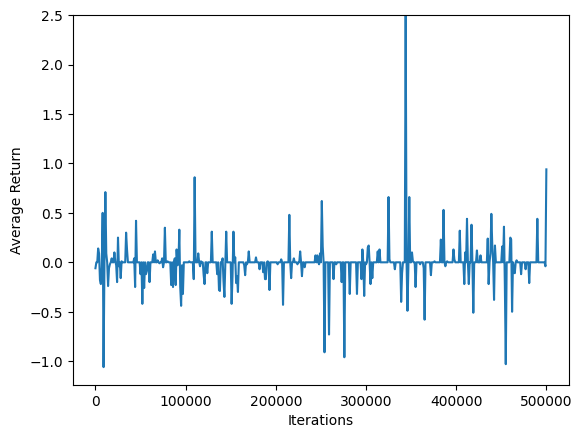

In [37]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=2.5)

# Test

In [38]:
test_py_env = TradingEnv(X_test)
test_env = tf_py_environment.TFPyEnvironment(test_py_env)

In [39]:
avg_return,avg_steps = compute_avg_return(test_env, agent.policy, num_eval_episodes)
returns_test = [avg_return]
steps_test = [avg_steps]

In [40]:
for i in range(X_test.shape[0]):
    avg_return,avg_steps = compute_avg_return(test_env, agent.policy, num_eval_episodes)
    print('iteration = {0}: steps = {1}, Return = {2}'.format(i,avg_steps, avg_return))
    returns_test.append(avg_return)
    steps_test.append(avg_steps)

iteration = 0: steps = 10.0, Return = -0.49000000953674316
iteration = 1: steps = 1.0, Return = 0.0
iteration = 2: steps = 1.0, Return = 0.0
iteration = 3: steps = 10.0, Return = 0.12999999523162842
iteration = 4: steps = 10.0, Return = 0.10000000149011612
iteration = 5: steps = 1.0, Return = 0.0
iteration = 6: steps = 1.0, Return = 0.0
iteration = 7: steps = 10.0, Return = -0.05000000074505806
iteration = 8: steps = 1.0, Return = 0.0
iteration = 9: steps = 1.0, Return = 0.0
iteration = 10: steps = 1.0, Return = 0.0
iteration = 11: steps = 1.0, Return = 0.0
iteration = 12: steps = 1.0, Return = 0.0
iteration = 13: steps = 1.0, Return = 0.0
iteration = 14: steps = 1.0, Return = 0.0
iteration = 15: steps = 1.0, Return = 0.0
iteration = 16: steps = 10.0, Return = -0.019999999552965164
iteration = 17: steps = 1.0, Return = 0.0
iteration = 18: steps = 1.0, Return = 0.0
iteration = 19: steps = 1.0, Return = 0.0
iteration = 20: steps = 10.0, Return = 0.0
iteration = 21: steps = 10.0, Return =

iteration = 161: steps = 10.0, Return = 0.07000000029802322
iteration = 162: steps = 10.0, Return = -0.14000000059604645
iteration = 163: steps = 10.0, Return = -0.05000000074505806
iteration = 164: steps = 1.0, Return = 0.0
iteration = 165: steps = 10.0, Return = -0.029999999329447746
iteration = 166: steps = 10.0, Return = -0.12999999523162842
iteration = 167: steps = 10.0, Return = 0.3499999940395355
iteration = 168: steps = 10.0, Return = -0.019999999552965164
iteration = 169: steps = 1.0, Return = 0.0
iteration = 170: steps = 10.0, Return = 0.10999999940395355
iteration = 171: steps = 10.0, Return = -0.03999999910593033
iteration = 172: steps = 10.0, Return = 0.009999999776482582
iteration = 173: steps = 1.0, Return = 0.0
iteration = 174: steps = 1.0, Return = 0.0
iteration = 175: steps = 1.0, Return = 0.0
iteration = 176: steps = 10.0, Return = 0.029999999329447746
iteration = 177: steps = 10.0, Return = 0.10999999940395355
iteration = 178: steps = 10.0, Return = 0.05000000074505

iteration = 317: steps = 10.0, Return = 0.11999999731779099
iteration = 318: steps = 1.0, Return = 0.0
iteration = 319: steps = 10.0, Return = 0.029999999329447746
iteration = 320: steps = 1.0, Return = 0.0
iteration = 321: steps = 1.0, Return = 0.0
iteration = 322: steps = 10.0, Return = -0.17000000178813934
iteration = 323: steps = 10.0, Return = 0.05999999865889549
iteration = 324: steps = 1.0, Return = 0.0
iteration = 325: steps = 10.0, Return = 0.6600000262260437
iteration = 326: steps = 10.0, Return = 0.019999999552965164
iteration = 327: steps = 10.0, Return = 0.07000000029802322
iteration = 328: steps = 10.0, Return = -0.15000000596046448
iteration = 329: steps = 1.0, Return = 0.0
iteration = 330: steps = 1.0, Return = 0.0
iteration = 331: steps = 10.0, Return = -0.20000000298023224
iteration = 332: steps = 10.0, Return = -0.07000000029802322
iteration = 333: steps = 10.0, Return = -0.10999999940395355
iteration = 334: steps = 10.0, Return = -0.09000000357627869
iteration = 335

iteration = 470: steps = 10.0, Return = 0.10000000149011612
iteration = 471: steps = 1.0, Return = 0.0
iteration = 472: steps = 10.0, Return = -0.11999999731779099
iteration = 473: steps = 10.0, Return = 0.029999999329447746
iteration = 474: steps = 1.0, Return = 0.0
iteration = 475: steps = 1.0, Return = 0.0
iteration = 476: steps = 1.0, Return = 0.0
iteration = 477: steps = 10.0, Return = -0.07000000029802322
iteration = 478: steps = 10.0, Return = -0.15000000596046448
iteration = 479: steps = 1.0, Return = 0.0
iteration = 480: steps = 1.0, Return = 0.0
iteration = 481: steps = 10.0, Return = -0.20999999344348907
iteration = 482: steps = 10.0, Return = -0.36000001430511475
iteration = 483: steps = 1.0, Return = 0.0
iteration = 484: steps = 1.0, Return = 0.0
iteration = 485: steps = 10.0, Return = 0.009999999776482582
iteration = 486: steps = 1.0, Return = 0.0
iteration = 487: steps = 10.0, Return = -0.09000000357627869
iteration = 488: steps = 10.0, Return = 0.0
iteration = 489: step

iteration = 627: steps = 10.0, Return = 0.1599999964237213
iteration = 628: steps = 1.0, Return = 0.0
iteration = 629: steps = 10.0, Return = 0.029999999329447746
iteration = 630: steps = 10.0, Return = 0.07000000029802322
iteration = 631: steps = 10.0, Return = 0.019999999552965164
iteration = 632: steps = 10.0, Return = -0.10000000149011612
iteration = 633: steps = 10.0, Return = 0.10999999940395355
iteration = 634: steps = 10.0, Return = -0.019999999552965164
iteration = 635: steps = 1.0, Return = 0.0
iteration = 636: steps = 1.0, Return = 0.0
iteration = 637: steps = 1.0, Return = 0.0
iteration = 638: steps = 1.0, Return = 0.0
iteration = 639: steps = 1.0, Return = 0.0
iteration = 640: steps = 10.0, Return = -0.07999999821186066
iteration = 641: steps = 1.0, Return = 0.0
iteration = 642: steps = 1.0, Return = 0.0
iteration = 643: steps = 1.0, Return = 0.0
iteration = 644: steps = 1.0, Return = 0.0
iteration = 645: steps = 1.0, Return = 0.0
iteration = 646: steps = 10.0, Return = 0.

iteration = 783: steps = 10.0, Return = 0.14000000059604645
iteration = 784: steps = 1.0, Return = 0.0
iteration = 785: steps = 1.0, Return = 0.0
iteration = 786: steps = 1.0, Return = 0.0
iteration = 787: steps = 1.0, Return = 0.0
iteration = 788: steps = 10.0, Return = 0.009999999776482582
iteration = 789: steps = 1.0, Return = 0.0
iteration = 790: steps = 10.0, Return = -0.05000000074505806
iteration = 791: steps = 1.0, Return = 0.0
iteration = 792: steps = 10.0, Return = 0.10999999940395355
iteration = 793: steps = 10.0, Return = -0.18000000715255737
iteration = 794: steps = 10.0, Return = 0.019999999552965164
iteration = 795: steps = 10.0, Return = -0.6899999976158142
iteration = 796: steps = 10.0, Return = -0.019999999552965164
iteration = 797: steps = 10.0, Return = 0.09000000357627869
iteration = 798: steps = 10.0, Return = 0.20000000298023224
iteration = 799: steps = 10.0, Return = 0.12999999523162842
iteration = 800: steps = 10.0, Return = -0.10000000149011612
iteration = 801

iteration = 938: steps = 10.0, Return = -0.05000000074505806
iteration = 939: steps = 10.0, Return = 0.7799999713897705
iteration = 940: steps = 10.0, Return = -0.09000000357627869
iteration = 941: steps = 10.0, Return = -0.009999999776482582
iteration = 942: steps = 1.0, Return = 0.0
iteration = 943: steps = 10.0, Return = 0.07999999821186066
iteration = 944: steps = 1.0, Return = 0.0
iteration = 945: steps = 10.0, Return = -0.17000000178813934
iteration = 946: steps = 10.0, Return = 0.03999999910593033
iteration = 947: steps = 1.0, Return = 0.0
iteration = 948: steps = 10.0, Return = 0.07000000029802322
iteration = 949: steps = 10.0, Return = -0.029999999329447746
iteration = 950: steps = 10.0, Return = 0.17000000178813934
iteration = 951: steps = 10.0, Return = -0.3400000035762787
iteration = 952: steps = 10.0, Return = -0.009999999776482582
iteration = 953: steps = 10.0, Return = 0.05999999865889549
iteration = 954: steps = 1.0, Return = 0.0
iteration = 955: steps = 1.0, Return = 0

iteration = 1093: steps = 10.0, Return = 0.14000000059604645
iteration = 1094: steps = 10.0, Return = 0.25
iteration = 1095: steps = 1.0, Return = 0.0
iteration = 1096: steps = 1.0, Return = 0.0
iteration = 1097: steps = 1.0, Return = 0.0
iteration = 1098: steps = 10.0, Return = -0.07000000029802322
iteration = 1099: steps = 1.0, Return = 0.0
iteration = 1100: steps = 10.0, Return = 0.1899999976158142
iteration = 1101: steps = 10.0, Return = 0.009999999776482582
iteration = 1102: steps = 1.0, Return = 0.0
iteration = 1103: steps = 1.0, Return = 0.0
iteration = 1104: steps = 10.0, Return = -0.11999999731779099
iteration = 1105: steps = 10.0, Return = 0.20000000298023224
iteration = 1106: steps = 1.0, Return = 0.0
iteration = 1107: steps = 10.0, Return = -0.18000000715255737
iteration = 1108: steps = 1.0, Return = 0.0
iteration = 1109: steps = 10.0, Return = 0.07000000029802322
iteration = 1110: steps = 1.0, Return = 0.0
iteration = 1111: steps = 1.0, Return = 0.0
iteration = 1112: steps

iteration = 1244: steps = 10.0, Return = -0.009999999776482582
iteration = 1245: steps = 1.0, Return = 0.0
iteration = 1246: steps = 10.0, Return = -0.15000000596046448
iteration = 1247: steps = 10.0, Return = 0.09000000357627869
iteration = 1248: steps = 10.0, Return = -0.2199999988079071
iteration = 1249: steps = 10.0, Return = -0.07999999821186066
iteration = 1250: steps = 10.0, Return = 0.17000000178813934
iteration = 1251: steps = 1.0, Return = 0.0
iteration = 1252: steps = 1.0, Return = 0.0
iteration = 1253: steps = 1.0, Return = 0.0
iteration = 1254: steps = 10.0, Return = 0.029999999329447746
iteration = 1255: steps = 1.0, Return = 0.0
iteration = 1256: steps = 10.0, Return = 0.20000000298023224
iteration = 1257: steps = 1.0, Return = 0.0
iteration = 1258: steps = 1.0, Return = 0.0
iteration = 1259: steps = 10.0, Return = -0.3199999928474426
iteration = 1260: steps = 10.0, Return = -0.12999999523162842
iteration = 1261: steps = 10.0, Return = 0.07000000029802322
iteration = 126

iteration = 1395: steps = 10.0, Return = -0.38999998569488525
iteration = 1396: steps = 1.0, Return = 0.0
iteration = 1397: steps = 10.0, Return = -0.12999999523162842
iteration = 1398: steps = 10.0, Return = 0.28999999165534973
iteration = 1399: steps = 10.0, Return = -0.019999999552965164
iteration = 1400: steps = 10.0, Return = -0.029999999329447746
iteration = 1401: steps = 10.0, Return = 0.2800000011920929
iteration = 1402: steps = 1.0, Return = 0.0
iteration = 1403: steps = 10.0, Return = 0.12999999523162842
iteration = 1404: steps = 10.0, Return = 0.4099999964237213
iteration = 1405: steps = 1.0, Return = 0.0
iteration = 1406: steps = 1.0, Return = 0.0
iteration = 1407: steps = 10.0, Return = -0.10999999940395355
iteration = 1408: steps = 10.0, Return = -0.38999998569488525
iteration = 1409: steps = 10.0, Return = -0.7900000214576721
iteration = 1410: steps = 10.0, Return = 0.5799999833106995
iteration = 1411: steps = 10.0, Return = -0.7300000190734863
iteration = 1412: steps = 

iteration = 1547: steps = 10.0, Return = -0.1899999976158142
iteration = 1548: steps = 1.0, Return = 0.0
iteration = 1549: steps = 1.0, Return = 0.0
iteration = 1550: steps = 10.0, Return = -0.009999999776482582
iteration = 1551: steps = 10.0, Return = -0.28999999165534973
iteration = 1552: steps = 10.0, Return = -0.14000000059604645
iteration = 1553: steps = 10.0, Return = 0.019999999552965164
iteration = 1554: steps = 1.0, Return = 0.0
iteration = 1555: steps = 1.0, Return = 0.0
iteration = 1556: steps = 10.0, Return = -0.05999999865889549
iteration = 1557: steps = 10.0, Return = -0.07000000029802322
iteration = 1558: steps = 1.0, Return = 0.0
iteration = 1559: steps = 10.0, Return = -0.07999999821186066
iteration = 1560: steps = 10.0, Return = 0.009999999776482582
iteration = 1561: steps = 1.0, Return = 0.0
iteration = 1562: steps = 10.0, Return = -0.029999999329447746
iteration = 1563: steps = 10.0, Return = 0.05000000074505806
iteration = 1564: steps = 10.0, Return = 1.64999997615

iteration = 1699: steps = 10.0, Return = 0.09000000357627869
iteration = 1700: steps = 10.0, Return = 0.30000001192092896
iteration = 1701: steps = 10.0, Return = -0.009999999776482582
iteration = 1702: steps = 10.0, Return = -0.4099999964237213
iteration = 1703: steps = 1.0, Return = 0.0
iteration = 1704: steps = 10.0, Return = 0.019999999552965164
iteration = 1705: steps = 10.0, Return = 0.05000000074505806
iteration = 1706: steps = 1.0, Return = 0.0
iteration = 1707: steps = 1.0, Return = 0.0
iteration = 1708: steps = 1.0, Return = 0.0
iteration = 1709: steps = 10.0, Return = -0.1599999964237213
iteration = 1710: steps = 10.0, Return = 0.09000000357627869
iteration = 1711: steps = 10.0, Return = -0.4399999976158142
iteration = 1712: steps = 10.0, Return = -0.10999999940395355
iteration = 1713: steps = 1.0, Return = 0.0
iteration = 1714: steps = 10.0, Return = 0.14000000059604645
iteration = 1715: steps = 1.0, Return = 0.0
iteration = 1716: steps = 10.0, Return = 0.41999998688697815


iteration = 1851: steps = 10.0, Return = -0.07999999821186066
iteration = 1852: steps = 10.0, Return = 0.4399999976158142
iteration = 1853: steps = 1.0, Return = 0.0
iteration = 1854: steps = 10.0, Return = 0.46000000834465027
iteration = 1855: steps = 10.0, Return = 0.2199999988079071
iteration = 1856: steps = 1.0, Return = 0.0
iteration = 1857: steps = 10.0, Return = 0.17000000178813934
iteration = 1858: steps = 10.0, Return = 0.009999999776482582
iteration = 1859: steps = 1.0, Return = 0.0
iteration = 1860: steps = 10.0, Return = 0.30000001192092896
iteration = 1861: steps = 10.0, Return = 0.029999999329447746
iteration = 1862: steps = 10.0, Return = 0.009999999776482582
iteration = 1863: steps = 1.0, Return = 0.0
iteration = 1864: steps = 10.0, Return = -0.30000001192092896
iteration = 1865: steps = 1.0, Return = 0.0
iteration = 1866: steps = 10.0, Return = -0.1899999976158142
iteration = 1867: steps = 1.0, Return = 0.0
iteration = 1868: steps = 10.0, Return = -0.1599999964237213
i

iteration = 1999: steps = 1.0, Return = 0.0
iteration = 2000: steps = 10.0, Return = -0.28999999165534973
iteration = 2001: steps = 10.0, Return = -0.23999999463558197
iteration = 2002: steps = 10.0, Return = 0.07999999821186066
iteration = 2003: steps = 10.0, Return = 0.07999999821186066
iteration = 2004: steps = 10.0, Return = 0.11999999731779099
iteration = 2005: steps = 10.0, Return = -0.03999999910593033
iteration = 2006: steps = 10.0, Return = 0.09000000357627869
iteration = 2007: steps = 1.0, Return = 0.0
iteration = 2008: steps = 10.0, Return = -0.3799999952316284
iteration = 2009: steps = 10.0, Return = -0.23000000417232513
iteration = 2010: steps = 1.0, Return = 0.0
iteration = 2011: steps = 1.0, Return = 0.0
iteration = 2012: steps = 1.0, Return = 0.0
iteration = 2013: steps = 1.0, Return = 0.0
iteration = 2014: steps = 1.0, Return = 0.0
iteration = 2015: steps = 10.0, Return = 0.1599999964237213
iteration = 2016: steps = 10.0, Return = -0.10999999940395355
iteration = 2017:

iteration = 2154: steps = 10.0, Return = 0.2800000011920929
iteration = 2155: steps = 10.0, Return = -0.09000000357627869
iteration = 2156: steps = 10.0, Return = -1.3877787807814457e-17
iteration = 2157: steps = 10.0, Return = -0.15000000596046448
iteration = 2158: steps = 10.0, Return = 0.07999999821186066
iteration = 2159: steps = 1.0, Return = 0.0
iteration = 2160: steps = 1.0, Return = 0.0
iteration = 2161: steps = 10.0, Return = -0.4000000059604645
iteration = 2162: steps = 10.0, Return = 0.05000000074505806
iteration = 2163: steps = 1.0, Return = 0.0
iteration = 2164: steps = 10.0, Return = 0.2199999988079071
iteration = 2165: steps = 10.0, Return = 0.23000000417232513
iteration = 2166: steps = 10.0, Return = -0.17000000178813934
iteration = 2167: steps = 1.0, Return = 0.0
iteration = 2168: steps = 1.0, Return = 0.0
iteration = 2169: steps = 1.0, Return = 0.0
iteration = 2170: steps = 1.0, Return = 0.0
iteration = 2171: steps = 10.0, Return = 0.07999999821186066
iteration = 2172

iteration = 2310: steps = 10.0, Return = -0.8299999833106995
iteration = 2311: steps = 1.0, Return = 0.0
iteration = 2312: steps = 1.0, Return = 0.0
iteration = 2313: steps = 1.0, Return = 0.0
iteration = 2314: steps = 10.0, Return = 0.009999999776482582
iteration = 2315: steps = 10.0, Return = -0.14000000059604645
iteration = 2316: steps = 1.0, Return = 0.0
iteration = 2317: steps = 10.0, Return = 0.27000001072883606
iteration = 2318: steps = 10.0, Return = -0.23000000417232513
iteration = 2319: steps = 1.0, Return = 0.0
iteration = 2320: steps = 1.0, Return = 0.0
iteration = 2321: steps = 10.0, Return = 1.3877787807814457e-17
iteration = 2322: steps = 1.0, Return = 0.0
iteration = 2323: steps = 10.0, Return = 0.05999999865889549
iteration = 2324: steps = 1.0, Return = 0.0
iteration = 2325: steps = 1.0, Return = 0.0
iteration = 2326: steps = 10.0, Return = -0.07000000029802322
iteration = 2327: steps = 10.0, Return = 0.09000000357627869
iteration = 2328: steps = 10.0, Return = -0.2800

iteration = 2463: steps = 10.0, Return = 0.1599999964237213
iteration = 2464: steps = 10.0, Return = 0.019999999552965164
iteration = 2465: steps = 1.0, Return = 0.0
iteration = 2466: steps = 10.0, Return = -0.20000000298023224
iteration = 2467: steps = 1.0, Return = 0.0
iteration = 2468: steps = 10.0, Return = 0.07000000029802322
iteration = 2469: steps = 1.0, Return = 0.0
iteration = 2470: steps = 10.0, Return = 0.03999999910593033
iteration = 2471: steps = 10.0, Return = 0.029999999329447746
iteration = 2472: steps = 1.0, Return = 0.0
iteration = 2473: steps = 10.0, Return = 0.30000001192092896
iteration = 2474: steps = 10.0, Return = -0.009999999776482582
iteration = 2475: steps = 1.0, Return = 0.0
iteration = 2476: steps = 1.0, Return = 0.0
iteration = 2477: steps = 10.0, Return = -0.07000000029802322
iteration = 2478: steps = 10.0, Return = 0.10999999940395355
iteration = 2479: steps = 10.0, Return = 0.05999999865889549
iteration = 2480: steps = 10.0, Return = -0.2599999904632568

iteration = 2611: steps = 10.0, Return = -0.009999999776482582
iteration = 2612: steps = 1.0, Return = 0.0
iteration = 2613: steps = 10.0, Return = 0.05000000074505806
iteration = 2614: steps = 1.0, Return = 0.0
iteration = 2615: steps = 10.0, Return = 0.0
iteration = 2616: steps = 10.0, Return = -0.18000000715255737
iteration = 2617: steps = 10.0, Return = 0.10000000149011612
iteration = 2618: steps = 1.0, Return = 0.0
iteration = 2619: steps = 10.0, Return = -0.11999999731779099
iteration = 2620: steps = 1.0, Return = 0.0
iteration = 2621: steps = 1.0, Return = 0.0
iteration = 2622: steps = 10.0, Return = 0.019999999552965164
iteration = 2623: steps = 1.0, Return = 0.0
iteration = 2624: steps = 10.0, Return = 0.20999999344348907
iteration = 2625: steps = 1.0, Return = 0.0
iteration = 2626: steps = 1.0, Return = 0.0
iteration = 2627: steps = 10.0, Return = 0.05999999865889549
iteration = 2628: steps = 10.0, Return = -0.009999999776482582
iteration = 2629: steps = 10.0, Return = 0.4399

iteration = 2767: steps = 10.0, Return = -0.05999999865889549
iteration = 2768: steps = 1.0, Return = 0.0
iteration = 2769: steps = 1.0, Return = 0.0
iteration = 2770: steps = 1.0, Return = 0.0
iteration = 2771: steps = 1.0, Return = 0.0
iteration = 2772: steps = 1.0, Return = 0.0
iteration = 2773: steps = 10.0, Return = 6.938893903907228e-18
iteration = 2774: steps = 10.0, Return = 0.07999999821186066
iteration = 2775: steps = 10.0, Return = -0.11999999731779099
iteration = 2776: steps = 10.0, Return = 0.14000000059604645
iteration = 2777: steps = 10.0, Return = 0.2199999988079071
iteration = 2778: steps = 10.0, Return = -6.938893903907228e-18
iteration = 2779: steps = 1.0, Return = 0.0
iteration = 2780: steps = 10.0, Return = 0.2199999988079071
iteration = 2781: steps = 1.0, Return = 0.0
iteration = 2782: steps = 10.0, Return = -0.11999999731779099
iteration = 2783: steps = 10.0, Return = -0.14000000059604645
iteration = 2784: steps = 10.0, Return = -0.019999999552965164
iteration = 

iteration = 2922: steps = 10.0, Return = -0.10999999940395355
iteration = 2923: steps = 1.0, Return = 0.0
iteration = 2924: steps = 10.0, Return = -0.7200000286102295
iteration = 2925: steps = 10.0, Return = 0.20000000298023224
iteration = 2926: steps = 1.0, Return = 0.0
iteration = 2927: steps = 10.0, Return = -0.1599999964237213
iteration = 2928: steps = 10.0, Return = 0.07999999821186066
iteration = 2929: steps = 1.0, Return = 0.0
iteration = 2930: steps = 10.0, Return = 0.28999999165534973
iteration = 2931: steps = 10.0, Return = -0.05000000074505806
iteration = 2932: steps = 1.0, Return = 0.0
iteration = 2933: steps = 10.0, Return = 0.05999999865889549
iteration = 2934: steps = 10.0, Return = -0.23000000417232513
iteration = 2935: steps = 10.0, Return = -0.1899999976158142
iteration = 2936: steps = 1.0, Return = 0.0
iteration = 2937: steps = 10.0, Return = -0.05999999865889549
iteration = 2938: steps = 10.0, Return = 0.27000001072883606
iteration = 2939: steps = 10.0, Return = 0.0

iteration = 3072: steps = 10.0, Return = 0.23999999463558197
iteration = 3073: steps = 1.0, Return = 0.0
iteration = 3074: steps = 1.0, Return = 0.0
iteration = 3075: steps = 10.0, Return = -0.10000000149011612
iteration = 3076: steps = 10.0, Return = -0.07999999821186066
iteration = 3077: steps = 1.0, Return = 0.0
iteration = 3078: steps = 10.0, Return = 0.05000000074505806
iteration = 3079: steps = 10.0, Return = -0.2800000011920929
iteration = 3080: steps = 10.0, Return = -0.07999999821186066
iteration = 3081: steps = 10.0, Return = 0.029999999329447746
iteration = 3082: steps = 10.0, Return = -0.38999998569488525
iteration = 3083: steps = 10.0, Return = 0.009999999776482582
iteration = 3084: steps = 10.0, Return = -0.3499999940395355
iteration = 3085: steps = 10.0, Return = -0.10999999940395355
iteration = 3086: steps = 10.0, Return = 0.11999999731779099
iteration = 3087: steps = 10.0, Return = 0.09000000357627869
iteration = 3088: steps = 1.0, Return = 0.0
iteration = 3089: steps 

iteration = 3227: steps = 10.0, Return = 0.47999998927116394
iteration = 3228: steps = 1.0, Return = 0.0
iteration = 3229: steps = 10.0, Return = 0.07999999821186066
iteration = 3230: steps = 10.0, Return = 0.05999999865889549
iteration = 3231: steps = 10.0, Return = -0.009999999776482582
iteration = 3232: steps = 1.0, Return = 0.0
iteration = 3233: steps = 10.0, Return = 0.029999999329447746
iteration = 3234: steps = 10.0, Return = -0.029999999329447746
iteration = 3235: steps = 10.0, Return = -0.05000000074505806
iteration = 3236: steps = 1.0, Return = 0.0
iteration = 3237: steps = 10.0, Return = -0.20000000298023224
iteration = 3238: steps = 10.0, Return = 0.6600000262260437
iteration = 3239: steps = 1.0, Return = 0.0
iteration = 3240: steps = 10.0, Return = -0.33000001311302185
iteration = 3241: steps = 10.0, Return = 0.09000000357627869
iteration = 3242: steps = 10.0, Return = -0.17000000178813934
iteration = 3243: steps = 10.0, Return = -0.15000000596046448
iteration = 3244: step

iteration = 3376: steps = 10.0, Return = 0.20000000298023224
iteration = 3377: steps = 10.0, Return = -0.12999999523162842
iteration = 3378: steps = 1.0, Return = 0.0
iteration = 3379: steps = 1.0, Return = 0.0
iteration = 3380: steps = 1.0, Return = 0.0
iteration = 3381: steps = 10.0, Return = 0.46000000834465027
iteration = 3382: steps = 1.0, Return = 0.0
iteration = 3383: steps = 1.0, Return = 0.0
iteration = 3384: steps = 1.0, Return = 0.0
iteration = 3385: steps = 10.0, Return = 0.3499999940395355
iteration = 3386: steps = 10.0, Return = -0.05000000074505806
iteration = 3387: steps = 10.0, Return = 0.14000000059604645
iteration = 3388: steps = 1.0, Return = 0.0
iteration = 3389: steps = 1.0, Return = 0.0
iteration = 3390: steps = 10.0, Return = 1.2300000190734863
iteration = 3391: steps = 10.0, Return = 0.07999999821186066
iteration = 3392: steps = 10.0, Return = 0.12999999523162842
iteration = 3393: steps = 10.0, Return = -0.05000000074505806
iteration = 3394: steps = 10.0, Retur

iteration = 3528: steps = 10.0, Return = -0.12999999523162842
iteration = 3529: steps = 10.0, Return = -0.6299999952316284
iteration = 3530: steps = 10.0, Return = -0.5699999928474426
iteration = 3531: steps = 1.0, Return = 0.0
iteration = 3532: steps = 1.0, Return = 0.0
iteration = 3533: steps = 1.0, Return = 0.0
iteration = 3534: steps = 1.0, Return = 0.0
iteration = 3535: steps = 10.0, Return = 0.23000000417232513
iteration = 3536: steps = 1.0, Return = 0.0
iteration = 3537: steps = 1.0, Return = 0.0
iteration = 3538: steps = 10.0, Return = 0.20999999344348907
iteration = 3539: steps = 10.0, Return = -0.10000000149011612
iteration = 3540: steps = 1.0, Return = 0.0
iteration = 3541: steps = 10.0, Return = 0.10000000149011612
iteration = 3542: steps = 10.0, Return = 0.09000000357627869
iteration = 3543: steps = 1.0, Return = 0.0
iteration = 3544: steps = 10.0, Return = 0.36000001430511475
iteration = 3545: steps = 1.0, Return = 0.0
iteration = 3546: steps = 10.0, Return = 0.2700000107

iteration = 3679: steps = 10.0, Return = 0.03999999910593033
iteration = 3680: steps = 10.0, Return = -0.07999999821186066
iteration = 3681: steps = 10.0, Return = 0.10000000149011612
iteration = 3682: steps = 1.0, Return = 0.0
iteration = 3683: steps = 10.0, Return = -1.734723475976807e-18
iteration = 3684: steps = 10.0, Return = -0.23000000417232513
iteration = 3685: steps = 1.0, Return = 0.0
iteration = 3686: steps = 10.0, Return = 0.15000000596046448
iteration = 3687: steps = 10.0, Return = 0.019999999552965164
iteration = 3688: steps = 10.0, Return = -0.6100000143051147
iteration = 3689: steps = 10.0, Return = -0.07000000029802322
iteration = 3690: steps = 10.0, Return = -0.699999988079071
iteration = 3691: steps = 1.0, Return = 0.0
iteration = 3692: steps = 1.0, Return = 0.0
iteration = 3693: steps = 10.0, Return = 0.019999999552965164
iteration = 3694: steps = 10.0, Return = -0.03999999910593033
iteration = 3695: steps = 1.0, Return = 0.0
iteration = 3696: steps = 1.0, Return = 

iteration = 3832: steps = 10.0, Return = 0.07999999821186066
iteration = 3833: steps = 1.0, Return = 0.0
iteration = 3834: steps = 1.0, Return = 0.0
iteration = 3835: steps = 1.0, Return = 0.0
iteration = 3836: steps = 1.0, Return = 0.0
iteration = 3837: steps = 10.0, Return = -0.20000000298023224
iteration = 3838: steps = 10.0, Return = -0.1599999964237213
iteration = 3839: steps = 10.0, Return = -0.07999999821186066
iteration = 3840: steps = 10.0, Return = -0.09000000357627869
iteration = 3841: steps = 10.0, Return = -0.3100000023841858
iteration = 3842: steps = 1.0, Return = 0.0
iteration = 3843: steps = 10.0, Return = 0.05999999865889549
iteration = 3844: steps = 10.0, Return = 0.029999999329447746
iteration = 3845: steps = 10.0, Return = -0.20999999344348907
iteration = 3846: steps = 10.0, Return = -0.009999999776482582
iteration = 3847: steps = 1.0, Return = 0.0
iteration = 3848: steps = 10.0, Return = -0.15000000596046448
iteration = 3849: steps = 10.0, Return = -0.0900000035762

iteration = 3983: steps = 10.0, Return = 0.10000000149011612
iteration = 3984: steps = 10.0, Return = 0.2199999988079071
iteration = 3985: steps = 10.0, Return = 0.9100000262260437
iteration = 3986: steps = 10.0, Return = -0.30000001192092896
iteration = 3987: steps = 10.0, Return = 0.009999999776482582
iteration = 3988: steps = 10.0, Return = 0.2800000011920929
iteration = 3989: steps = 10.0, Return = -0.25
iteration = 3990: steps = 10.0, Return = 0.20000000298023224
iteration = 3991: steps = 1.0, Return = 0.0
iteration = 3992: steps = 10.0, Return = 0.029999999329447746
iteration = 3993: steps = 1.0, Return = 0.0
iteration = 3994: steps = 10.0, Return = -0.1599999964237213
iteration = 3995: steps = 1.0, Return = 0.0
iteration = 3996: steps = 10.0, Return = 0.029999999329447746
iteration = 3997: steps = 10.0, Return = 0.009999999776482582
iteration = 3998: steps = 1.0, Return = 0.0
iteration = 3999: steps = 10.0, Return = 0.03999999910593033
iteration = 4000: steps = 1.0, Return = 0.0

iteration = 4135: steps = 10.0, Return = 0.029999999329447746
iteration = 4136: steps = 1.0, Return = 0.0
iteration = 4137: steps = 10.0, Return = -0.03999999910593033
iteration = 4138: steps = 10.0, Return = -0.10000000149011612
iteration = 4139: steps = 10.0, Return = -0.1899999976158142
iteration = 4140: steps = 1.0, Return = 0.0
iteration = 4141: steps = 10.0, Return = 0.1899999976158142
iteration = 4142: steps = 10.0, Return = -0.07999999821186066
iteration = 4143: steps = 10.0, Return = 0.3700000047683716
iteration = 4144: steps = 1.0, Return = 0.0
iteration = 4145: steps = 10.0, Return = 0.07999999821186066
iteration = 4146: steps = 10.0, Return = -0.05999999865889549
iteration = 4147: steps = 1.0, Return = 0.0
iteration = 4148: steps = 10.0, Return = -1.3877787807814457e-17
iteration = 4149: steps = 1.0, Return = 0.0
iteration = 4150: steps = 10.0, Return = -0.25999999046325684
iteration = 4151: steps = 10.0, Return = 0.5
iteration = 4152: steps = 10.0, Return = -0.159999996423

iteration = 4293: steps = 10.0, Return = 0.009999999776482582
iteration = 4294: steps = 10.0, Return = 1.1100000143051147
iteration = 4295: steps = 10.0, Return = -1.1799999475479126
iteration = 4296: steps = 1.0, Return = 0.0
iteration = 4297: steps = 10.0, Return = -0.10000000149011612
iteration = 4298: steps = 1.0, Return = 0.0
iteration = 4299: steps = 10.0, Return = -0.10999999940395355
iteration = 4300: steps = 1.0, Return = 0.0
iteration = 4301: steps = 10.0, Return = 0.15000000596046448
iteration = 4302: steps = 1.0, Return = 0.0
iteration = 4303: steps = 1.0, Return = 0.0
iteration = 4304: steps = 1.0, Return = 0.0
iteration = 4305: steps = 1.0, Return = 0.0
iteration = 4306: steps = 10.0, Return = 0.10000000149011612
iteration = 4307: steps = 1.0, Return = 0.0
iteration = 4308: steps = 1.0, Return = 0.0
iteration = 4309: steps = 1.0, Return = 0.0
iteration = 4310: steps = 10.0, Return = -0.09000000357627869
iteration = 4311: steps = 10.0, Return = 3.469446951953614e-18
iterat

iteration = 4444: steps = 10.0, Return = -0.6499999761581421
iteration = 4445: steps = 10.0, Return = 0.10000000149011612
iteration = 4446: steps = 10.0, Return = 0.029999999329447746
iteration = 4447: steps = 10.0, Return = -0.10000000149011612
iteration = 4448: steps = 1.0, Return = 0.0
iteration = 4449: steps = 10.0, Return = 0.12999999523162842
iteration = 4450: steps = 10.0, Return = 0.20000000298023224
iteration = 4451: steps = 1.0, Return = 0.0
iteration = 4452: steps = 1.0, Return = 0.0
iteration = 4453: steps = 10.0, Return = -0.03999999910593033
iteration = 4454: steps = 10.0, Return = 0.05999999865889549
iteration = 4455: steps = 10.0, Return = 0.07000000029802322
iteration = 4456: steps = 10.0, Return = 0.17000000178813934
iteration = 4457: steps = 10.0, Return = 0.2800000011920929
iteration = 4458: steps = 1.0, Return = 0.0
iteration = 4459: steps = 10.0, Return = -1.0408340855860843e-17
iteration = 4460: steps = 1.0, Return = 0.0
iteration = 4461: steps = 1.0, Return = 0.

iteration = 4601: steps = 10.0, Return = 0.05000000074505806
iteration = 4602: steps = 1.0, Return = 0.0
iteration = 4603: steps = 10.0, Return = -0.23000000417232513
iteration = 4604: steps = 1.0, Return = 0.0
iteration = 4605: steps = 10.0, Return = 0.03999999910593033
iteration = 4606: steps = 10.0, Return = 0.05999999865889549
iteration = 4607: steps = 10.0, Return = 0.019999999552965164
iteration = 4608: steps = 10.0, Return = 0.03999999910593033
iteration = 4609: steps = 10.0, Return = 0.05999999865889549
iteration = 4610: steps = 1.0, Return = 0.0
iteration = 4611: steps = 1.0, Return = 0.0
iteration = 4612: steps = 10.0, Return = -0.20999999344348907
iteration = 4613: steps = 1.0, Return = 0.0
iteration = 4614: steps = 10.0, Return = 0.05999999865889549
iteration = 4615: steps = 10.0, Return = 0.18000000715255737
iteration = 4616: steps = 10.0, Return = 0.009999999776482582
iteration = 4617: steps = 10.0, Return = -0.11999999731779099
iteration = 4618: steps = 1.0, Return = 0.0

iteration = 4755: steps = 10.0, Return = 0.009999999776482582
iteration = 4756: steps = 10.0, Return = 2.7755575615628914e-17
iteration = 4757: steps = 10.0, Return = 0.23000000417232513
iteration = 4758: steps = 1.0, Return = 0.0
iteration = 4759: steps = 1.0, Return = 0.0
iteration = 4760: steps = 10.0, Return = -0.33000001311302185
iteration = 4761: steps = 10.0, Return = -0.2199999988079071
iteration = 4762: steps = 10.0, Return = -0.03999999910593033
iteration = 4763: steps = 10.0, Return = 0.019999999552965164
iteration = 4764: steps = 10.0, Return = 0.09000000357627869
iteration = 4765: steps = 1.0, Return = 0.0
iteration = 4766: steps = 1.0, Return = 0.0
iteration = 4767: steps = 10.0, Return = -0.019999999552965164
iteration = 4768: steps = 1.0, Return = 0.0
iteration = 4769: steps = 10.0, Return = -0.10000000149011612
iteration = 4770: steps = 1.0, Return = 0.0
iteration = 4771: steps = 10.0, Return = 0.3100000023841858
iteration = 4772: steps = 10.0, Return = -0.019999999552

iteration = 4905: steps = 10.0, Return = -0.38999998569488525
iteration = 4906: steps = 1.0, Return = 0.0
iteration = 4907: steps = 1.0, Return = 0.0
iteration = 4908: steps = 1.0, Return = 0.0
iteration = 4909: steps = 10.0, Return = 0.05000000074505806
iteration = 4910: steps = 1.0, Return = 0.0
iteration = 4911: steps = 1.0, Return = 0.0
iteration = 4912: steps = 10.0, Return = -0.20999999344348907
iteration = 4913: steps = 1.0, Return = 0.0
iteration = 4914: steps = 1.0, Return = 0.0
iteration = 4915: steps = 1.0, Return = 0.0
iteration = 4916: steps = 10.0, Return = -0.029999999329447746
iteration = 4917: steps = 1.0, Return = 0.0
iteration = 4918: steps = 10.0, Return = -0.27000001072883606
iteration = 4919: steps = 10.0, Return = -0.18000000715255737
iteration = 4920: steps = 10.0, Return = 0.7900000214576721
iteration = 4921: steps = 10.0, Return = 0.10000000149011612
iteration = 4922: steps = 10.0, Return = -0.3100000023841858
iteration = 4923: steps = 1.0, Return = 0.0
iterat

iteration = 5060: steps = 10.0, Return = 0.3700000047683716
iteration = 5061: steps = 10.0, Return = 0.07000000029802322
iteration = 5062: steps = 1.0, Return = 0.0
iteration = 5063: steps = 1.0, Return = 0.0
iteration = 5064: steps = 10.0, Return = 1.7200000286102295
iteration = 5065: steps = 10.0, Return = -0.07000000029802322
iteration = 5066: steps = 10.0, Return = -0.009999999776482582
iteration = 5067: steps = 1.0, Return = 0.0
iteration = 5068: steps = 10.0, Return = -0.07999999821186066
iteration = 5069: steps = 10.0, Return = 0.10999999940395355
iteration = 5070: steps = 1.0, Return = 0.0
iteration = 5071: steps = 10.0, Return = -0.10000000149011612
iteration = 5072: steps = 1.0, Return = 0.0
iteration = 5073: steps = 1.0, Return = 0.0
iteration = 5074: steps = 10.0, Return = -0.3499999940395355
iteration = 5075: steps = 10.0, Return = -0.7900000214576721
iteration = 5076: steps = 10.0, Return = -0.23000000417232513
iteration = 5077: steps = 1.0, Return = 0.0
iteration = 5078:

iteration = 5207: steps = 10.0, Return = 0.05999999865889549
iteration = 5208: steps = 10.0, Return = 0.03999999910593033
iteration = 5209: steps = 10.0, Return = -0.09000000357627869
iteration = 5210: steps = 10.0, Return = 0.1899999976158142
iteration = 5211: steps = 10.0, Return = -0.019999999552965164
iteration = 5212: steps = 1.0, Return = 0.0
iteration = 5213: steps = 10.0, Return = -0.11999999731779099
iteration = 5214: steps = 10.0, Return = 0.30000001192092896
iteration = 5215: steps = 1.0, Return = 0.0
iteration = 5216: steps = 1.0, Return = 0.0
iteration = 5217: steps = 10.0, Return = -0.029999999329447746
iteration = 5218: steps = 10.0, Return = 0.14000000059604645
iteration = 5219: steps = 10.0, Return = 0.0
iteration = 5220: steps = 10.0, Return = -0.009999999776482582
iteration = 5221: steps = 1.0, Return = 0.0
iteration = 5222: steps = 10.0, Return = 0.07000000029802322
iteration = 5223: steps = 1.0, Return = 0.0
iteration = 5224: steps = 1.0, Return = 0.0
iteration = 5

iteration = 5362: steps = 1.0, Return = 0.0
iteration = 5363: steps = 10.0, Return = -0.07999999821186066
iteration = 5364: steps = 10.0, Return = -0.05000000074505806
iteration = 5365: steps = 1.0, Return = 0.0
iteration = 5366: steps = 10.0, Return = 0.05999999865889549
iteration = 5367: steps = 10.0, Return = -0.3199999928474426
iteration = 5368: steps = 1.0, Return = 0.0
iteration = 5369: steps = 10.0, Return = 0.4099999964237213
iteration = 5370: steps = 10.0, Return = -0.029999999329447746
iteration = 5371: steps = 1.0, Return = 0.0
iteration = 5372: steps = 10.0, Return = -0.25999999046325684
iteration = 5373: steps = 10.0, Return = 0.25999999046325684
iteration = 5374: steps = 1.0, Return = 0.0
iteration = 5375: steps = 10.0, Return = 0.27000001072883606
iteration = 5376: steps = 10.0, Return = -0.05000000074505806
iteration = 5377: steps = 1.0, Return = 0.0
iteration = 5378: steps = 10.0, Return = 0.12999999523162842
iteration = 5379: steps = 10.0, Return = -0.0099999997764825

iteration = 5515: steps = 10.0, Return = 0.2800000011920929
iteration = 5516: steps = 10.0, Return = -0.11999999731779099
iteration = 5517: steps = 1.0, Return = 0.0
iteration = 5518: steps = 1.0, Return = 0.0
iteration = 5519: steps = 1.0, Return = 0.0
iteration = 5520: steps = 1.0, Return = 0.0
iteration = 5521: steps = 10.0, Return = -0.10000000149011612
iteration = 5522: steps = 1.0, Return = 0.0
iteration = 5523: steps = 10.0, Return = 0.25
iteration = 5524: steps = 10.0, Return = 0.03999999910593033
iteration = 5525: steps = 1.0, Return = 0.0
iteration = 5526: steps = 10.0, Return = -0.019999999552965164
iteration = 5527: steps = 10.0, Return = -0.03999999910593033
iteration = 5528: steps = 10.0, Return = 3.469446951953614e-18
iteration = 5529: steps = 10.0, Return = 0.03999999910593033
iteration = 5530: steps = 1.0, Return = 0.0
iteration = 5531: steps = 1.0, Return = 0.0
iteration = 5532: steps = 1.0, Return = 0.0
iteration = 5533: steps = 10.0, Return = 0.09000000357627869
ite

iteration = 5669: steps = 10.0, Return = 0.1599999964237213
iteration = 5670: steps = 1.0, Return = 0.0
iteration = 5671: steps = 10.0, Return = 0.05000000074505806
iteration = 5672: steps = 10.0, Return = -0.1599999964237213
iteration = 5673: steps = 10.0, Return = -0.2199999988079071
iteration = 5674: steps = 10.0, Return = -5.204170427930421e-18
iteration = 5675: steps = 1.0, Return = 0.0
iteration = 5676: steps = 10.0, Return = -0.10000000149011612
iteration = 5677: steps = 10.0, Return = 0.11999999731779099
iteration = 5678: steps = 10.0, Return = -0.18000000715255737
iteration = 5679: steps = 10.0, Return = 0.07999999821186066
iteration = 5680: steps = 1.0, Return = 0.0
iteration = 5681: steps = 1.0, Return = 0.0
iteration = 5682: steps = 10.0, Return = 0.30000001192092896
iteration = 5683: steps = 10.0, Return = -0.18000000715255737
iteration = 5684: steps = 10.0, Return = -0.03999999910593033
iteration = 5685: steps = 1.0, Return = 0.0
iteration = 5686: steps = 1.0, Return = 0.

iteration = 5820: steps = 10.0, Return = 0.18000000715255737
iteration = 5821: steps = 10.0, Return = 0.009999999776482582
iteration = 5822: steps = 10.0, Return = 0.07000000029802322
iteration = 5823: steps = 10.0, Return = -0.3499999940395355
iteration = 5824: steps = 1.0, Return = 0.0
iteration = 5825: steps = 1.0, Return = 0.0
iteration = 5826: steps = 10.0, Return = -0.019999999552965164
iteration = 5827: steps = 10.0, Return = -0.10000000149011612
iteration = 5828: steps = 10.0, Return = 0.029999999329447746
iteration = 5829: steps = 10.0, Return = 1.3877787807814457e-17
iteration = 5830: steps = 10.0, Return = -0.20999999344348907
iteration = 5831: steps = 10.0, Return = 0.07999999821186066
iteration = 5832: steps = 10.0, Return = 0.20000000298023224
iteration = 5833: steps = 1.0, Return = 0.0
iteration = 5834: steps = 10.0, Return = -0.09000000357627869
iteration = 5835: steps = 1.0, Return = 0.0
iteration = 5836: steps = 1.0, Return = 0.0
iteration = 5837: steps = 1.0, Return 

iteration = 5970: steps = 10.0, Return = 0.10999999940395355
iteration = 5971: steps = 1.0, Return = 0.0
iteration = 5972: steps = 10.0, Return = -0.10999999940395355
iteration = 5973: steps = 10.0, Return = -0.05000000074505806
iteration = 5974: steps = 10.0, Return = -0.36000001430511475
iteration = 5975: steps = 10.0, Return = 0.1899999976158142
iteration = 5976: steps = 10.0, Return = -0.07999999821186066
iteration = 5977: steps = 10.0, Return = -0.03999999910593033
iteration = 5978: steps = 1.0, Return = 0.0
iteration = 5979: steps = 10.0, Return = -0.05999999865889549
iteration = 5980: steps = 1.0, Return = 0.0
iteration = 5981: steps = 10.0, Return = -0.029999999329447746
iteration = 5982: steps = 10.0, Return = -0.10999999940395355
iteration = 5983: steps = 1.0, Return = 0.0
iteration = 5984: steps = 10.0, Return = 0.1899999976158142
iteration = 5985: steps = 10.0, Return = -0.14000000059604645
iteration = 5986: steps = 10.0, Return = -0.15000000596046448
iteration = 5987: step

iteration = 6121: steps = 10.0, Return = -0.7599999904632568
iteration = 6122: steps = 10.0, Return = 0.0
iteration = 6123: steps = 10.0, Return = -0.05999999865889549
iteration = 6124: steps = 1.0, Return = 0.0
iteration = 6125: steps = 10.0, Return = 0.07999999821186066
iteration = 6126: steps = 1.0, Return = 0.0
iteration = 6127: steps = 10.0, Return = 0.009999999776482582
iteration = 6128: steps = 10.0, Return = -0.20999999344348907
iteration = 6129: steps = 10.0, Return = -0.09000000357627869
iteration = 6130: steps = 10.0, Return = -0.10999999940395355
iteration = 6131: steps = 1.0, Return = 0.0
iteration = 6132: steps = 10.0, Return = -0.019999999552965164
iteration = 6133: steps = 1.0, Return = 0.0
iteration = 6134: steps = 10.0, Return = 0.019999999552965164
iteration = 6135: steps = 10.0, Return = -0.20999999344348907
iteration = 6136: steps = 10.0, Return = -0.18000000715255737
iteration = 6137: steps = 1.0, Return = 0.0
iteration = 6138: steps = 10.0, Return = -0.0900000035

iteration = 6275: steps = 10.0, Return = 0.009999999776482582
iteration = 6276: steps = 10.0, Return = -0.07999999821186066
iteration = 6277: steps = 1.0, Return = 0.0
iteration = 6278: steps = 10.0, Return = -0.3400000035762787
iteration = 6279: steps = 10.0, Return = -0.15000000596046448
iteration = 6280: steps = 10.0, Return = 0.10000000149011612
iteration = 6281: steps = 10.0, Return = 0.10999999940395355
iteration = 6282: steps = 1.0, Return = 0.0
iteration = 6283: steps = 10.0, Return = -0.2800000011920929
iteration = 6284: steps = 1.0, Return = 0.0
iteration = 6285: steps = 10.0, Return = 0.6700000166893005
iteration = 6286: steps = 10.0, Return = 0.05999999865889549
iteration = 6287: steps = 1.0, Return = 0.0
iteration = 6288: steps = 1.0, Return = 0.0
iteration = 6289: steps = 10.0, Return = -0.14000000059604645
iteration = 6290: steps = 10.0, Return = -0.05000000074505806
iteration = 6291: steps = 10.0, Return = -0.05000000074505806
iteration = 6292: steps = 10.0, Return = 0.

iteration = 6423: steps = 1.0, Return = 0.0
iteration = 6424: steps = 1.0, Return = 0.0
iteration = 6425: steps = 10.0, Return = 0.10999999940395355
iteration = 6426: steps = 10.0, Return = -0.05000000074505806
iteration = 6427: steps = 10.0, Return = 0.019999999552965164
iteration = 6428: steps = 1.0, Return = 0.0
iteration = 6429: steps = 1.0, Return = 0.0
iteration = 6430: steps = 1.0, Return = 0.0
iteration = 6431: steps = 10.0, Return = 0.009999999776482582
iteration = 6432: steps = 10.0, Return = -0.07000000029802322
iteration = 6433: steps = 10.0, Return = -0.12999999523162842
iteration = 6434: steps = 10.0, Return = 0.029999999329447746
iteration = 6435: steps = 10.0, Return = 0.17000000178813934
iteration = 6436: steps = 10.0, Return = 0.009999999776482582
iteration = 6437: steps = 1.0, Return = 0.0
iteration = 6438: steps = 1.0, Return = 0.0
iteration = 6439: steps = 10.0, Return = -0.009999999776482582
iteration = 6440: steps = 1.0, Return = 0.0
iteration = 6441: steps = 10.

iteration = 6577: steps = 10.0, Return = 0.009999999776482582
iteration = 6578: steps = 10.0, Return = 0.25
iteration = 6579: steps = 10.0, Return = 0.05999999865889549
iteration = 6580: steps = 10.0, Return = 0.17000000178813934
iteration = 6581: steps = 1.0, Return = 0.0
iteration = 6582: steps = 1.0, Return = 0.0
iteration = 6583: steps = 10.0, Return = 0.03999999910593033
iteration = 6584: steps = 10.0, Return = -0.18000000715255737
iteration = 6585: steps = 10.0, Return = 0.1899999976158142
iteration = 6586: steps = 1.0, Return = 0.0
iteration = 6587: steps = 10.0, Return = -0.05999999865889549
iteration = 6588: steps = 10.0, Return = -0.3700000047683716
iteration = 6589: steps = 1.0, Return = 0.0
iteration = 6590: steps = 1.0, Return = 0.0
iteration = 6591: steps = 1.0, Return = 0.0
iteration = 6592: steps = 1.0, Return = 0.0
iteration = 6593: steps = 10.0, Return = 0.05000000074505806
iteration = 6594: steps = 10.0, Return = 0.03999999910593033
iteration = 6595: steps = 10.0, Re

iteration = 6730: steps = 10.0, Return = -0.03999999910593033
iteration = 6731: steps = 10.0, Return = -0.23999999463558197
iteration = 6732: steps = 1.0, Return = 0.0
iteration = 6733: steps = 10.0, Return = 0.009999999776482582
iteration = 6734: steps = 10.0, Return = -0.10000000149011612
iteration = 6735: steps = 10.0, Return = -0.03999999910593033
iteration = 6736: steps = 10.0, Return = 0.12999999523162842
iteration = 6737: steps = 10.0, Return = -0.3400000035762787
iteration = 6738: steps = 10.0, Return = -0.25
iteration = 6739: steps = 10.0, Return = -0.07999999821186066
iteration = 6740: steps = 10.0, Return = 0.20999999344348907
iteration = 6741: steps = 10.0, Return = -0.07000000029802322
iteration = 6742: steps = 1.0, Return = 0.0
iteration = 6743: steps = 1.0, Return = 0.0
iteration = 6744: steps = 1.0, Return = 0.0
iteration = 6745: steps = 10.0, Return = 0.3100000023841858
iteration = 6746: steps = 10.0, Return = -0.10999999940395355
iteration = 6747: steps = 10.0, Return

iteration = 6882: steps = 10.0, Return = 0.10000000149011612
iteration = 6883: steps = 1.0, Return = 0.0
iteration = 6884: steps = 10.0, Return = -0.14000000059604645
iteration = 6885: steps = 10.0, Return = -0.09000000357627869
iteration = 6886: steps = 10.0, Return = 0.15000000596046448
iteration = 6887: steps = 10.0, Return = 0.44999998807907104
iteration = 6888: steps = 10.0, Return = 0.019999999552965164
iteration = 6889: steps = 1.0, Return = 0.0
iteration = 6890: steps = 10.0, Return = -0.10000000149011612
iteration = 6891: steps = 10.0, Return = -0.12999999523162842
iteration = 6892: steps = 1.0, Return = 0.0
iteration = 6893: steps = 10.0, Return = 0.6299999952316284
iteration = 6894: steps = 1.0, Return = 0.0
iteration = 6895: steps = 10.0, Return = -0.6700000166893005
iteration = 6896: steps = 1.0, Return = 0.0
iteration = 6897: steps = 10.0, Return = 0.05000000074505806
iteration = 6898: steps = 1.0, Return = 0.0
iteration = 6899: steps = 10.0, Return = 0.07999999821186066


iteration = 7029: steps = 10.0, Return = 0.3799999952316284
iteration = 7030: steps = 10.0, Return = 0.4699999988079071
iteration = 7031: steps = 10.0, Return = 0.05000000074505806
iteration = 7032: steps = 10.0, Return = 0.10000000149011612
iteration = 7033: steps = 1.0, Return = 0.0
iteration = 7034: steps = 10.0, Return = 0.46000000834465027
iteration = 7035: steps = 1.0, Return = 0.0
iteration = 7036: steps = 1.0, Return = 0.0
iteration = 7037: steps = 10.0, Return = -0.12999999523162842
iteration = 7038: steps = 1.0, Return = 0.0
iteration = 7039: steps = 1.0, Return = 0.0
iteration = 7040: steps = 10.0, Return = 0.09000000357627869
iteration = 7041: steps = 10.0, Return = -0.05000000074505806
iteration = 7042: steps = 10.0, Return = -0.14000000059604645
iteration = 7043: steps = 10.0, Return = -0.07000000029802322
iteration = 7044: steps = 1.0, Return = 0.0
iteration = 7045: steps = 10.0, Return = -0.07000000029802322
iteration = 7046: steps = 10.0, Return = -0.05999999865889549


iteration = 7184: steps = 10.0, Return = -0.11999999731779099
iteration = 7185: steps = 10.0, Return = -0.11999999731779099
iteration = 7186: steps = 10.0, Return = 0.11999999731779099
iteration = 7187: steps = 10.0, Return = 0.1599999964237213
iteration = 7188: steps = 1.0, Return = 0.0
iteration = 7189: steps = 10.0, Return = 0.009999999776482582
iteration = 7190: steps = 1.0, Return = 0.0
iteration = 7191: steps = 10.0, Return = -0.029999999329447746
iteration = 7192: steps = 1.0, Return = 0.0
iteration = 7193: steps = 10.0, Return = 0.05000000074505806
iteration = 7194: steps = 10.0, Return = -0.03999999910593033
iteration = 7195: steps = 10.0, Return = -0.05000000074505806
iteration = 7196: steps = 1.0, Return = 0.0
iteration = 7197: steps = 1.0, Return = 0.0
iteration = 7198: steps = 10.0, Return = -0.07000000029802322
iteration = 7199: steps = 10.0, Return = -0.23999999463558197
iteration = 7200: steps = 10.0, Return = 0.12999999523162842
iteration = 7201: steps = 10.0, Return =

iteration = 7335: steps = 10.0, Return = -0.05999999865889549
iteration = 7336: steps = 10.0, Return = 0.09000000357627869
iteration = 7337: steps = 10.0, Return = 0.019999999552965164
iteration = 7338: steps = 10.0, Return = 0.10000000149011612
iteration = 7339: steps = 10.0, Return = -0.07999999821186066
iteration = 7340: steps = 1.0, Return = 0.0
iteration = 7341: steps = 10.0, Return = -0.03999999910593033
iteration = 7342: steps = 10.0, Return = 0.12999999523162842
iteration = 7343: steps = 10.0, Return = 0.28999999165534973
iteration = 7344: steps = 1.0, Return = 0.0
iteration = 7345: steps = 10.0, Return = -0.07000000029802322
iteration = 7346: steps = 1.0, Return = 0.0
iteration = 7347: steps = 1.0, Return = 0.0
iteration = 7348: steps = 1.0, Return = 0.0
iteration = 7349: steps = 1.0, Return = 0.0
iteration = 7350: steps = 10.0, Return = -0.14000000059604645
iteration = 7351: steps = 1.0, Return = 0.0
iteration = 7352: steps = 1.0, Return = 0.0
iteration = 7353: steps = 10.0, 

iteration = 7486: steps = 10.0, Return = -0.2800000011920929
iteration = 7487: steps = 1.0, Return = 0.0
iteration = 7488: steps = 10.0, Return = 0.25
iteration = 7489: steps = 10.0, Return = 0.03999999910593033
iteration = 7490: steps = 10.0, Return = 0.05000000074505806
iteration = 7491: steps = 10.0, Return = 0.05000000074505806
iteration = 7492: steps = 1.0, Return = 0.0
iteration = 7493: steps = 1.0, Return = 0.0
iteration = 7494: steps = 10.0, Return = 0.019999999552965164
iteration = 7495: steps = 1.0, Return = 0.0
iteration = 7496: steps = 10.0, Return = 0.41999998688697815
iteration = 7497: steps = 1.0, Return = 0.0
iteration = 7498: steps = 1.0, Return = 0.0
iteration = 7499: steps = 1.0, Return = 0.0
iteration = 7500: steps = 1.0, Return = 0.0
iteration = 7501: steps = 10.0, Return = 0.27000001072883606
iteration = 7502: steps = 10.0, Return = -0.25999999046325684
iteration = 7503: steps = 1.0, Return = 0.0
iteration = 7504: steps = 10.0, Return = 0.14000000059604645
iterati

iteration = 7642: steps = 10.0, Return = -0.10999999940395355
iteration = 7643: steps = 10.0, Return = -0.11999999731779099
iteration = 7644: steps = 10.0, Return = 0.10999999940395355
iteration = 7645: steps = 10.0, Return = 0.07999999821186066
iteration = 7646: steps = 1.0, Return = 0.0
iteration = 7647: steps = 4.0, Return = -3.4800000190734863
iteration = 7648: steps = 1.0, Return = 0.0
iteration = 7649: steps = 1.0, Return = 0.0
iteration = 7650: steps = 1.0, Return = 0.0
iteration = 7651: steps = 1.0, Return = 0.0
iteration = 7652: steps = 10.0, Return = -0.1899999976158142
iteration = 7653: steps = 10.0, Return = -0.07000000029802322
iteration = 7654: steps = 10.0, Return = 0.20000000298023224
iteration = 7655: steps = 10.0, Return = 0.3199999928474426
iteration = 7656: steps = 10.0, Return = 0.07999999821186066
iteration = 7657: steps = 10.0, Return = -0.12999999523162842
iteration = 7658: steps = 10.0, Return = 0.10999999940395355
iteration = 7659: steps = 10.0, Return = -0.15

iteration = 7791: steps = 10.0, Return = -0.25999999046325684
iteration = 7792: steps = 10.0, Return = -0.17000000178813934
iteration = 7793: steps = 10.0, Return = -0.4399999976158142
iteration = 7794: steps = 1.0, Return = 0.0
iteration = 7795: steps = 1.0, Return = 0.0
iteration = 7796: steps = 10.0, Return = 0.41999998688697815
iteration = 7797: steps = 1.0, Return = 0.0
iteration = 7798: steps = 10.0, Return = -0.009999999776482582
iteration = 7799: steps = 1.0, Return = 0.0
iteration = 7800: steps = 1.0, Return = 0.0
iteration = 7801: steps = 1.0, Return = 0.0
iteration = 7802: steps = 1.0, Return = 0.0
iteration = 7803: steps = 10.0, Return = 0.019999999552965164
iteration = 7804: steps = 10.0, Return = -0.029999999329447746
iteration = 7805: steps = 1.0, Return = 0.0
iteration = 7806: steps = 10.0, Return = 0.0
iteration = 7807: steps = 10.0, Return = -0.2800000011920929
iteration = 7808: steps = 10.0, Return = 0.05000000074505806
iteration = 7809: steps = 10.0, Return = 0.0500

iteration = 7940: steps = 10.0, Return = 0.009999999776482582
iteration = 7941: steps = 1.0, Return = 0.0
iteration = 7942: steps = 10.0, Return = -0.25
iteration = 7943: steps = 10.0, Return = 0.14000000059604645
iteration = 7944: steps = 1.0, Return = 0.0
iteration = 7945: steps = 10.0, Return = -0.15000000596046448
iteration = 7946: steps = 10.0, Return = 0.05000000074505806
iteration = 7947: steps = 1.0, Return = 0.0
iteration = 7948: steps = 10.0, Return = -0.20999999344348907
iteration = 7949: steps = 1.0, Return = 0.0
iteration = 7950: steps = 1.0, Return = 0.0
iteration = 7951: steps = 10.0, Return = -0.05999999865889549
iteration = 7952: steps = 10.0, Return = 0.1599999964237213
iteration = 7953: steps = 1.0, Return = 0.0
iteration = 7954: steps = 10.0, Return = -0.019999999552965164
iteration = 7955: steps = 1.0, Return = 0.0
iteration = 7956: steps = 10.0, Return = 1.0499999523162842
iteration = 7957: steps = 10.0, Return = 0.11999999731779099
iteration = 7958: steps = 10.0,

iteration = 8091: steps = 10.0, Return = 0.07999999821186066
iteration = 8092: steps = 10.0, Return = -0.8899999856948853
iteration = 8093: steps = 1.0, Return = 0.0
iteration = 8094: steps = 10.0, Return = 0.09000000357627869
iteration = 8095: steps = 1.0, Return = 0.0
iteration = 8096: steps = 10.0, Return = -0.03999999910593033
iteration = 8097: steps = 10.0, Return = -0.10999999940395355
iteration = 8098: steps = 1.0, Return = 0.0
iteration = 8099: steps = 1.0, Return = 0.0
iteration = 8100: steps = 10.0, Return = -0.23999999463558197
iteration = 8101: steps = 10.0, Return = 3.469446951953614e-18
iteration = 8102: steps = 10.0, Return = 0.2800000011920929
iteration = 8103: steps = 1.0, Return = 0.0
iteration = 8104: steps = 1.0, Return = 0.0
iteration = 8105: steps = 1.0, Return = 0.0
iteration = 8106: steps = 10.0, Return = -0.05999999865889549
iteration = 8107: steps = 10.0, Return = 0.1599999964237213
iteration = 8108: steps = 10.0, Return = -0.10999999940395355
iteration = 8109

iteration = 8246: steps = 10.0, Return = -0.009999999776482582
iteration = 8247: steps = 1.0, Return = 0.0
iteration = 8248: steps = 10.0, Return = -0.019999999552965164
iteration = 8249: steps = 10.0, Return = -0.09000000357627869
iteration = 8250: steps = 10.0, Return = -0.27000001072883606
iteration = 8251: steps = 10.0, Return = 0.05999999865889549
iteration = 8252: steps = 10.0, Return = 0.029999999329447746
iteration = 8253: steps = 10.0, Return = 0.2199999988079071
iteration = 8254: steps = 1.0, Return = 0.0
iteration = 8255: steps = 1.0, Return = 0.0
iteration = 8256: steps = 10.0, Return = 0.009999999776482582
iteration = 8257: steps = 10.0, Return = -0.14000000059604645
iteration = 8258: steps = 1.0, Return = 0.0
iteration = 8259: steps = 10.0, Return = -0.029999999329447746
iteration = 8260: steps = 1.0, Return = 0.0
iteration = 8261: steps = 10.0, Return = -0.10999999940395355
iteration = 8262: steps = 10.0, Return = 0.9300000071525574
iteration = 8263: steps = 10.0, Return

iteration = 8396: steps = 10.0, Return = -0.3799999952316284
iteration = 8397: steps = 10.0, Return = -0.029999999329447746
iteration = 8398: steps = 1.0, Return = 0.0
iteration = 8399: steps = 1.0, Return = 0.0
iteration = 8400: steps = 1.0, Return = 0.0
iteration = 8401: steps = 10.0, Return = 0.3700000047683716
iteration = 8402: steps = 10.0, Return = -0.14000000059604645
iteration = 8403: steps = 10.0, Return = -0.07000000029802322
iteration = 8404: steps = 10.0, Return = 0.14000000059604645
iteration = 8405: steps = 10.0, Return = 0.05999999865889549
iteration = 8406: steps = 10.0, Return = -0.09000000357627869
iteration = 8407: steps = 1.0, Return = 0.0
iteration = 8408: steps = 10.0, Return = 0.15000000596046448
iteration = 8409: steps = 10.0, Return = 0.019999999552965164
iteration = 8410: steps = 10.0, Return = 0.019999999552965164
iteration = 8411: steps = 1.0, Return = 0.0
iteration = 8412: steps = 10.0, Return = 0.15000000596046448
iteration = 8413: steps = 10.0, Return = 0

iteration = 8550: steps = 10.0, Return = -0.10999999940395355
iteration = 8551: steps = 1.0, Return = 0.0
iteration = 8552: steps = 10.0, Return = -0.15000000596046448
iteration = 8553: steps = 1.0, Return = 0.0
iteration = 8554: steps = 10.0, Return = -0.10999999940395355
iteration = 8555: steps = 1.0, Return = 0.0
iteration = 8556: steps = 10.0, Return = 0.1599999964237213
iteration = 8557: steps = 1.0, Return = 0.0
iteration = 8558: steps = 10.0, Return = 0.05999999865889549
iteration = 8559: steps = 1.0, Return = 0.0
iteration = 8560: steps = 10.0, Return = -0.33000001311302185
iteration = 8561: steps = 1.0, Return = 0.0
iteration = 8562: steps = 10.0, Return = -0.10000000149011612
iteration = 8563: steps = 10.0, Return = 0.03999999910593033
iteration = 8564: steps = 1.0, Return = 0.0
iteration = 8565: steps = 10.0, Return = 0.6299999952316284
iteration = 8566: steps = 10.0, Return = 0.14000000059604645
iteration = 8567: steps = 1.0, Return = 0.0
iteration = 8568: steps = 1.0, Retu

iteration = 8706: steps = 10.0, Return = 0.019999999552965164
iteration = 8707: steps = 10.0, Return = -0.1899999976158142
iteration = 8708: steps = 1.0, Return = 0.0
iteration = 8709: steps = 10.0, Return = -0.03999999910593033
iteration = 8710: steps = 10.0, Return = -0.019999999552965164
iteration = 8711: steps = 1.0, Return = 0.0
iteration = 8712: steps = 10.0, Return = -0.1899999976158142
iteration = 8713: steps = 10.0, Return = 0.10999999940395355
iteration = 8714: steps = 1.0, Return = 0.0
iteration = 8715: steps = 10.0, Return = -0.03999999910593033
iteration = 8716: steps = 10.0, Return = -0.10999999940395355
iteration = 8717: steps = 10.0, Return = -0.10999999940395355
iteration = 8718: steps = 10.0, Return = 0.15000000596046448
iteration = 8719: steps = 1.0, Return = 0.0
iteration = 8720: steps = 10.0, Return = 0.019999999552965164
iteration = 8721: steps = 10.0, Return = 0.6299999952316284
iteration = 8722: steps = 10.0, Return = -0.23999999463558197
iteration = 8723: steps

iteration = 8856: steps = 10.0, Return = 0.029999999329447746
iteration = 8857: steps = 10.0, Return = 0.029999999329447746
iteration = 8858: steps = 1.0, Return = 0.0
iteration = 8859: steps = 1.0, Return = 0.0
iteration = 8860: steps = 1.0, Return = 0.0
iteration = 8861: steps = 1.0, Return = 0.0
iteration = 8862: steps = 10.0, Return = -0.23999999463558197
iteration = 8863: steps = 1.0, Return = 0.0
iteration = 8864: steps = 10.0, Return = 0.3100000023841858
iteration = 8865: steps = 10.0, Return = 0.03999999910593033
iteration = 8866: steps = 10.0, Return = -1.0408340855860843e-17
iteration = 8867: steps = 10.0, Return = -0.15000000596046448
iteration = 8868: steps = 1.0, Return = 0.0
iteration = 8869: steps = 10.0, Return = -0.17000000178813934
iteration = 8870: steps = 10.0, Return = 0.11999999731779099
iteration = 8871: steps = 10.0, Return = 0.019999999552965164
iteration = 8872: steps = 1.0, Return = 0.0
iteration = 8873: steps = 10.0, Return = -0.25
iteration = 8874: steps = 

iteration = 9012: steps = 10.0, Return = -0.07000000029802322
iteration = 9013: steps = 10.0, Return = -0.47999998927116394
iteration = 9014: steps = 10.0, Return = 0.019999999552965164
iteration = 9015: steps = 1.0, Return = 0.0
iteration = 9016: steps = 10.0, Return = -0.09000000357627869
iteration = 9017: steps = 10.0, Return = 0.20999999344348907
iteration = 9018: steps = 1.0, Return = 0.0
iteration = 9019: steps = 10.0, Return = 0.05999999865889549
iteration = 9020: steps = 10.0, Return = 0.15000000596046448
iteration = 9021: steps = 10.0, Return = 0.23000000417232513
iteration = 9022: steps = 1.0, Return = 0.0
iteration = 9023: steps = 1.0, Return = 0.0
iteration = 9024: steps = 1.0, Return = 0.0
iteration = 9025: steps = 1.0, Return = 0.0
iteration = 9026: steps = 10.0, Return = 0.009999999776482582
iteration = 9027: steps = 1.0, Return = 0.0
iteration = 9028: steps = 10.0, Return = -0.6600000262260437
iteration = 9029: steps = 10.0, Return = -0.05999999865889549
iteration = 903

iteration = 9164: steps = 10.0, Return = -0.2800000011920929
iteration = 9165: steps = 10.0, Return = -0.1899999976158142
iteration = 9166: steps = 1.0, Return = 0.0
iteration = 9167: steps = 10.0, Return = 0.4099999964237213
iteration = 9168: steps = 1.0, Return = 0.0
iteration = 9169: steps = 10.0, Return = -0.12999999523162842
iteration = 9170: steps = 1.0, Return = 0.0
iteration = 9171: steps = 1.0, Return = 0.0
iteration = 9172: steps = 10.0, Return = 0.05999999865889549
iteration = 9173: steps = 10.0, Return = -0.1599999964237213
iteration = 9174: steps = 1.0, Return = 0.0
iteration = 9175: steps = 1.0, Return = 0.0
iteration = 9176: steps = 1.0, Return = 0.0
iteration = 9177: steps = 1.0, Return = 0.0
iteration = 9178: steps = 1.0, Return = 0.0
iteration = 9179: steps = 10.0, Return = 0.10999999940395355
iteration = 9180: steps = 10.0, Return = 0.029999999329447746
iteration = 9181: steps = 1.0, Return = 0.0
iteration = 9182: steps = 1.0, Return = 0.0
iteration = 9183: steps = 1

iteration = 9319: steps = 10.0, Return = -0.14000000059604645
iteration = 9320: steps = 10.0, Return = 0.10999999940395355
iteration = 9321: steps = 10.0, Return = 0.49000000953674316
iteration = 9322: steps = 10.0, Return = 0.05999999865889549
iteration = 9323: steps = 1.0, Return = 0.0
iteration = 9324: steps = 10.0, Return = 0.019999999552965164
iteration = 9325: steps = 1.0, Return = 0.0
iteration = 9326: steps = 10.0, Return = -0.25
iteration = 9327: steps = 10.0, Return = -0.14000000059604645
iteration = 9328: steps = 10.0, Return = -0.029999999329447746
iteration = 9329: steps = 1.0, Return = 0.0
iteration = 9330: steps = 1.0, Return = 0.0
iteration = 9331: steps = 1.0, Return = 0.0
iteration = 9332: steps = 1.0, Return = 0.0
iteration = 9333: steps = 10.0, Return = -0.03999999910593033
iteration = 9334: steps = 10.0, Return = 0.1599999964237213
iteration = 9335: steps = 10.0, Return = -0.12999999523162842
iteration = 9336: steps = 1.0, Return = 0.0
iteration = 9337: steps = 10.

iteration = 9472: steps = 10.0, Return = 0.3700000047683716
iteration = 9473: steps = 10.0, Return = 0.38999998569488525
iteration = 9474: steps = 10.0, Return = -0.03999999910593033
iteration = 9475: steps = 1.0, Return = 0.0
iteration = 9476: steps = 10.0, Return = 0.03999999910593033
iteration = 9477: steps = 10.0, Return = -0.33000001311302185
iteration = 9478: steps = 10.0, Return = -0.09000000357627869
iteration = 9479: steps = 10.0, Return = -0.05000000074505806
iteration = 9480: steps = 10.0, Return = -0.019999999552965164
iteration = 9481: steps = 10.0, Return = -0.11999999731779099
iteration = 9482: steps = 1.0, Return = 0.0
iteration = 9483: steps = 1.0, Return = 0.0
iteration = 9484: steps = 10.0, Return = -0.019999999552965164
iteration = 9485: steps = 10.0, Return = -0.09000000357627869
iteration = 9486: steps = 10.0, Return = -0.3400000035762787
iteration = 9487: steps = 10.0, Return = -0.019999999552965164
iteration = 9488: steps = 10.0, Return = 0.10000000149011612
ite

iteration = 9627: steps = 10.0, Return = -0.05999999865889549
iteration = 9628: steps = 10.0, Return = -0.05999999865889549
iteration = 9629: steps = 10.0, Return = -0.05000000074505806
iteration = 9630: steps = 1.0, Return = 0.0
iteration = 9631: steps = 1.0, Return = 0.0
iteration = 9632: steps = 10.0, Return = -0.28999999165534973
iteration = 9633: steps = 10.0, Return = -0.10999999940395355
iteration = 9634: steps = 10.0, Return = 0.3199999928474426
iteration = 9635: steps = 10.0, Return = 0.17000000178813934
iteration = 9636: steps = 10.0, Return = -0.009999999776482582
iteration = 9637: steps = 10.0, Return = -0.20999999344348907
iteration = 9638: steps = 10.0, Return = -0.38999998569488525
iteration = 9639: steps = 10.0, Return = -1.7599999904632568
iteration = 9640: steps = 1.0, Return = 0.0
iteration = 9641: steps = 10.0, Return = -0.3100000023841858
iteration = 9642: steps = 10.0, Return = 0.20000000298023224
iteration = 9643: steps = 10.0, Return = 0.28999999165534973
iterat

iteration = 9780: steps = 10.0, Return = -0.23000000417232513
iteration = 9781: steps = 10.0, Return = 0.05000000074505806
iteration = 9782: steps = 10.0, Return = 0.019999999552965164
iteration = 9783: steps = 10.0, Return = -0.15000000596046448
iteration = 9784: steps = 1.0, Return = 0.0
iteration = 9785: steps = 10.0, Return = 0.10999999940395355
iteration = 9786: steps = 10.0, Return = -0.10999999940395355
iteration = 9787: steps = 10.0, Return = -0.009999999776482582
iteration = 9788: steps = 10.0, Return = -0.05000000074505806
iteration = 9789: steps = 10.0, Return = -0.41999998688697815
iteration = 9790: steps = 1.0, Return = 0.0
iteration = 9791: steps = 10.0, Return = 0.30000001192092896
iteration = 9792: steps = 10.0, Return = -0.17000000178813934
iteration = 9793: steps = 1.0, Return = 0.0
iteration = 9794: steps = 1.0, Return = 0.0
iteration = 9795: steps = 10.0, Return = -0.009999999776482582
iteration = 9796: steps = 10.0, Return = 0.05999999865889549
iteration = 9797: st

iteration = 9927: steps = 10.0, Return = 0.09000000357627869
iteration = 9928: steps = 10.0, Return = 0.17000000178813934
iteration = 9929: steps = 1.0, Return = 0.0
iteration = 9930: steps = 10.0, Return = 0.5699999928474426
iteration = 9931: steps = 10.0, Return = 0.05000000074505806
iteration = 9932: steps = 10.0, Return = 0.27000001072883606
iteration = 9933: steps = 1.0, Return = 0.0
iteration = 9934: steps = 10.0, Return = 0.09000000357627869
iteration = 9935: steps = 10.0, Return = 0.05999999865889549
iteration = 9936: steps = 10.0, Return = -0.3100000023841858
iteration = 9937: steps = 10.0, Return = -0.029999999329447746
iteration = 9938: steps = 10.0, Return = 0.12999999523162842
iteration = 9939: steps = 1.0, Return = 0.0
iteration = 9940: steps = 10.0, Return = -0.029999999329447746
iteration = 9941: steps = 1.0, Return = 0.0
iteration = 9942: steps = 1.0, Return = 0.0
iteration = 9943: steps = 10.0, Return = 0.25
iteration = 9944: steps = 1.0, Return = 0.0
iteration = 9945

iteration = 10077: steps = 10.0, Return = -0.20999999344348907
iteration = 10078: steps = 1.0, Return = 0.0
iteration = 10079: steps = 10.0, Return = 0.029999999329447746
iteration = 10080: steps = 1.0, Return = 0.0
iteration = 10081: steps = 1.0, Return = 0.0
iteration = 10082: steps = 1.0, Return = 0.0
iteration = 10083: steps = 10.0, Return = -0.17000000178813934
iteration = 10084: steps = 10.0, Return = -0.3199999928474426
iteration = 10085: steps = 1.0, Return = 0.0
iteration = 10086: steps = 10.0, Return = -0.07000000029802322
iteration = 10087: steps = 10.0, Return = -0.1899999976158142
iteration = 10088: steps = 10.0, Return = -0.12999999523162842
iteration = 10089: steps = 10.0, Return = -0.10999999940395355
iteration = 10090: steps = 1.0, Return = 0.0
iteration = 10091: steps = 10.0, Return = -0.2199999988079071
iteration = 10092: steps = 10.0, Return = -0.09000000357627869
iteration = 10093: steps = 1.0, Return = 0.0
iteration = 10094: steps = 10.0, Return = -0.0399999991059

iteration = 10228: steps = 10.0, Return = -0.009999999776482582
iteration = 10229: steps = 1.0, Return = 0.0
iteration = 10230: steps = 1.0, Return = 0.0
iteration = 10231: steps = 10.0, Return = 0.4000000059604645
iteration = 10232: steps = 10.0, Return = -0.03999999910593033
iteration = 10233: steps = 1.0, Return = 0.0
iteration = 10234: steps = 10.0, Return = 0.17000000178813934
iteration = 10235: steps = 10.0, Return = 0.4699999988079071
iteration = 10236: steps = 10.0, Return = -0.33000001311302185
iteration = 10237: steps = 10.0, Return = -0.019999999552965164
iteration = 10238: steps = 1.0, Return = 0.0
iteration = 10239: steps = 1.0, Return = 0.0
iteration = 10240: steps = 10.0, Return = 0.009999999776482582
iteration = 10241: steps = 10.0, Return = -0.03999999910593033
iteration = 10242: steps = 1.0, Return = 0.0
iteration = 10243: steps = 10.0, Return = -0.10000000149011612
iteration = 10244: steps = 1.0, Return = 0.0
iteration = 10245: steps = 10.0, Return = -0.3199999928474

iteration = 10376: steps = 10.0, Return = 0.20999999344348907
iteration = 10377: steps = 10.0, Return = 0.05000000074505806
iteration = 10378: steps = 1.0, Return = 0.0
iteration = 10379: steps = 1.0, Return = 0.0
iteration = 10380: steps = 10.0, Return = -0.07000000029802322
iteration = 10381: steps = 10.0, Return = -0.10000000149011612
iteration = 10382: steps = 10.0, Return = 0.3100000023841858
iteration = 10383: steps = 10.0, Return = -0.10999999940395355
iteration = 10384: steps = 10.0, Return = -0.7300000190734863
iteration = 10385: steps = 10.0, Return = 0.019999999552965164
iteration = 10386: steps = 10.0, Return = 0.7200000286102295
iteration = 10387: steps = 10.0, Return = -0.019999999552965164
iteration = 10388: steps = 10.0, Return = 0.05000000074505806
iteration = 10389: steps = 10.0, Return = 0.07999999821186066
iteration = 10390: steps = 10.0, Return = -1.1100000143051147
iteration = 10391: steps = 10.0, Return = -0.10000000149011612
iteration = 10392: steps = 1.0, Retur

(-5.623999762535095, 5.0)

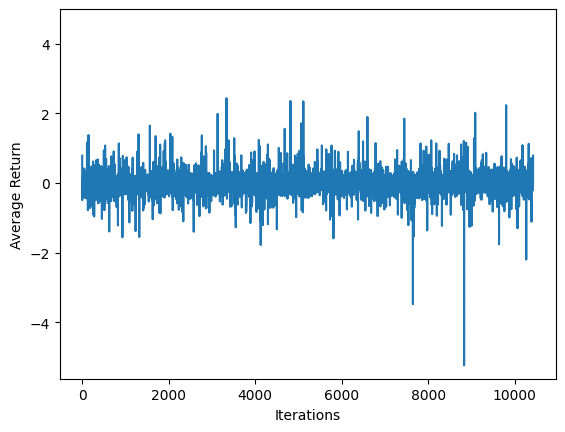

In [41]:
plt.plot(returns_test)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=5)

In [42]:
reward_money = returns_test.copy()

array_neg = []
array_pos = []
positive = 0
negative = 0
zero = 0
for reward in reward_money:
    if reward < 0:
        negative += 1
        array_neg.append(reward)
    elif reward > 0:
        positive += 1
        array_pos.append(reward)
    else:
        zero += 1
        
percent_neg = round((negative*100)/len(reward_money),2)
percent_pos = round((positive*100)/len(reward_money),2)
percent_zero = round((zero*100)/len(reward_money),2)

print("\rpositive: {}/{numero}\nnegative: {}/{numero}\nzero: {}/{numero}\n".format(positive, negative,zero
                                                                    ,numero=len(reward_money))
                                                                      , end="") # Not shown
print("Pos_percent {}%".format(percent_pos))
print("Neg_percent {}%".format(percent_neg))
print("zero_percent {}%".format(percent_zero))
print('max:'+str(max(reward_money)))
print('min:'+str(min(reward_money)))
print('total_money_win:' + str(sum(array_pos)))
print('total_money_loss:' + str(sum(array_neg)))
print('median_win:'+str(np.median(np.array(array_pos))))
print('median_neg:'+str(np.median(np.array(array_neg))))

positive: 3129/10429
negative: 3342/10429
zero: 3958/10429
Pos_percent 30.0%
Neg_percent 32.05%
zero_percent 37.95%
max:2.44
min:-5.24
total_money_win:556.3999995607883
total_money_loss:-584.5299994852394
median_win:0.11
median_neg:-0.12


In [ ]:
#import os
#from tf_agents.policies import policy_saver

#policy_dir = os.path.join('/home/jorge/Documentos/TFG/politicas', 'policy_funciona')
#tf_policy_saver = policy_saver.PolicySaver(agent.policy)

#tf_policy_saver.save(policy_dir)